# Предсказание вида (аспекта) сербских глаголов
## _На материалах UD_Serbian-SET_
### Импорты, настройки, глобальные переменные

In [1]:
import pandas as pd
import csv
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import FeatureImportances

import numpy as np
from gensim.models import Word2Vec

import torch
from itertools import product
from tqdm import tqdm
import re

from sklearn.model_selection import train_test_split
import numpy as np

import datetime
from nltk import word_tokenize

In [2]:
class Log:

    cols = ["experiment_name", "experiment_group", "model_name", "PCA", "F1_cv", "F1_holdout", "F1_unkn"]

    def __init__(self, fname: Path, sep: str):

        self.fname = fname
        self.sep = sep

        if not self.fname.exists():
            with open(fname, "w", encoding="utf-8") as file:
                file.write(self.sep.join(self.cols) + "\n")

    def write(self, vals):
        with open(self.fname, "a+", encoding="utf-8") as file:
            file.write(self.sep.join(vals) + "\n")

In [3]:
PAD_TOK = "[PAD]"
RANDOM_STATE = 42

DATADIR = Path.cwd() / "data"
DATAPATH = DATADIR / "datasetForAnalysis.csv"

LOGNAME_TMPL = datetime.datetime.now().strftime("%I-%M%p on %B %d %Y.csv")
SEP = "\t"

%matplotlib inline
SNS_COLOR = "coolwarm"

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings("ignore")

In [4]:
LOG = Log(DATADIR / LOGNAME_TMPL, SEP)

### Вспомогательные функции

In [5]:
def plot_corr(X: pd.DataFrame, trh=0.33):

    X_cpy = X.copy(deep=True)

    label_encoder = LabelEncoder()
    for column in X_cpy.columns:
        X_cpy[column] = label_encoder.fit_transform(X_cpy[column])

    corr= X_cpy.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(
        corr,
        mask=np.abs(corr) < trh,
        annot=True,
        fmt=".2f",
        cmap=SNS_COLOR,
        vmin=-1,
        vmax=1
    )
    plt.title("Correlation Matrix")
    plt.show()

In [6]:
def plot_freqs(df, col, hue=None, n=20):

    if hue:
        counts = df.groupby([col, hue]).size().reset_index(name="count")
    else:
        counts = df[col].value_counts().reset_index()

    top_n = df[col].value_counts().iloc[:n].index
    counts = counts[counts[col].isin(top_n)]

    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=counts,
        x=col,
        y="count",
        palette=SNS_COLOR,
        hue=hue,
    )
    plt.xticks(rotation=30)
    plt.title(f"{col.capitalize()} Counts")
    plt.tight_layout()
    plt.show()

In [7]:
def plot_metrics(df, m, min_=0.1):
    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=df,
        x="experiment_name",
        y=m,
        hue="model_name",
        palette=SNS_COLOR,
        errorbar=None,
    )
    plt.xlabel("Experiment")
    plt.ylabel(f"{m} Score")
    plt.ylim(min_, 1.0)
    plt.tick_params(axis="x", rotation=30)

    plt.show()

In [8]:
def one_hot_encode(X_train:pd.DataFrame, *X_tests: list[pd.DataFrame]):

    X_train_cpy = X_train.copy(deep=True)

    X_tests_cpy = [
        X_test.copy(deep=True)
        for X_test
        in X_tests
    ]

    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    pandas_columns = X_train_cpy.columns

    X_train_cpy = pd.DataFrame(encoder.fit_transform(X_train_cpy))
    X_tests_cpy = [
        pd.DataFrame(encoder.transform(X_test_cpy))
        for X_test_cpy
        in X_tests_cpy
    ]

    new_columns = encoder.get_feature_names_out(pandas_columns)
    new_columns = [re.sub(r"\[|\]", "_", col) for col in new_columns]

    X_train_cpy.columns = new_columns
    for X_test_cpy in X_tests_cpy:
        X_test_cpy.columns = new_columns

    return X_train_cpy, *X_tests_cpy

In [9]:
def pca_shrink(n, X_train:pd.DataFrame, *X_tests: list[pd.DataFrame]):

    X_train_cpy = X_train.copy(deep=True)

    X_tests_cpy = [
        X_test.copy(deep=True)
        for X_test
        in X_tests
    ]

    encoder = PCA(n_components=n)

    X_train_cpy = pd.DataFrame(encoder.fit_transform(X_train_cpy))
    X_tests_cpy = [
        pd.DataFrame(encoder.transform(X_test_cpy))
        for X_test_cpy
        in X_tests_cpy
    ]

    return X_train_cpy, *X_tests_cpy

In [10]:
def onehot_and_pca(n, X_train:pd.DataFrame, *X_tests: list[pd.DataFrame]):
    X_train_onehot, *X_tests_onehot = one_hot_encode(X_train, *X_tests)
    return pca_shrink(n, X_train_onehot, *X_tests_onehot)

In [11]:
def cross_val(model, X, y):
    return np.mean(
        cross_val_score(
            model,
            X,
            y,
            cv=KFold(
                n_splits=5,
                shuffle=True,
                random_state=RANDOM_STATE
            ),
            scoring="f1_weighted"
        )
    )

In [12]:
def experiment(
    experiment_name,
    experiment_group,
    get_model,
    X_train,
    X_test_holdout,
    X_test_unkn,
    y_train,
    y_test_holdout,
    y_test_unkn,
    log=None,
    cv=False,
    confusion=False,
    report=False,
    fi=False,
    pca=False
):

    model = get_model()
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)
    preds_holdout = model.predict(X_test_holdout)
    preds_unkn    = model.predict(X_test_unkn)

    to_print = [f"\n--- {experiment_name}: {model_name} ---\n"]

    f1_wtd_holdout = f1_score(y_test_holdout, preds_holdout, average="weighted")
    f1_wtd_unkn    = f1_score(y_test_unkn, preds_unkn, average="weighted")
    to_print.append(f"F1 weighted (Holdout): {f1_wtd_holdout:.3f}")
    to_print.append(f"F1 weighted (Unknown): {f1_wtd_unkn:.3f}")

    if cv:
        cv_f1 = cross_val(model, X_train, y_train)
        to_print.append(f"CV F1: {cv_f1:.3f}")
    else:
        cv_f1 = None

    if confusion:
        confusions_holdount = confusion_matrix(y_test_holdout, preds_holdout)
        confusions_unkn     = confusion_matrix(y_test_unkn, preds_unkn)
        to_print.append("Holdout confusion matrix")
        to_print.append(confusions_holdount)
        to_print.append("Unknown confusion matrix")
        to_print.append(confusions_unkn)

    if report:
        holdout_report = classification_report(
            y_test_holdout,
            preds_holdout,
            zero_division=1.0
        )
        unkn_report = classification_report(
            y_test_unkn,
            preds_unkn,
            zero_division=1.0
        )
        to_print.append("Holdout report:")
        to_print.append(holdout_report)
        to_print.append("Unknown report:")
        to_print.append(unkn_report)

    list(
        map(lambda string: print(string, "\n"), to_print)
    )

    if fi:
        viz = FeatureImportances(model, relative=False, topn=min(X_train.shape[1], 25))
        viz.fit(X_train, y_train)
        viz.show()

    if log is not None:
        log.write(
            [
                str(experiment_name),
                str(experiment_group),
                str(model_name),
                str(pca),
                str(np.round(cv_f1         , decimals=3)),
                str(np.round(f1_wtd_holdout, decimals=3)),
                str(np.round(f1_wtd_unkn   , decimals=3)),
            ]
        )

### Загрузка и подготовка датасета

In [13]:
df = pd.read_csv(
    DATAPATH,
    sep="\t",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    dtype=str
)

In [14]:
df = df.drop(["POS", "db_id"], axis=1)

In [15]:
df = df.fillna(PAD_TOK)

In [16]:
df["aspect"] = df["disambig"]

In [17]:
for _, row in df.iterrows():
    if row["aspect"] != row["disambig"]:
        print(_)

In [18]:
df.head()

,lemma,word,aspect,disambig,text,Gender,Mood,Number,Person,Tense,...,nsubj,nsubj_count,obj,obj_count,obl,obl_count,advmod,advmod_count,polarity,polarity_word
0,bacati,baca,imp,imp,"Otpad iz šest priobalnih zemalja, kao i država...",[PAD],Ind,Sing,3,Pres,...,[PAD],0,[PAD],0,[PAD],0,[PAD],0,pos,[PAD]
1,bacati,bacaju,imp,imp,Kosovski Srbi bacaju kamenje na vojnike KFOR-a...,[PAD],Ind,Plur,3,Pres,...,[PAD],0,[PAD],0,ponedeljak,1,[PAD],0,pos,[PAD]
2,bacati,bacaju,imp,imp,"""Umesto da bacaju mulj 25-30 km prema pučini, ...",[PAD],Ind,Plur,3,Pres,...,[PAD],0,[PAD],0,[PAD],0,[PAD],0,pos,[PAD]
3,bacati,bacaju,imp,imp,Blokirani razgovori sa MMF bacaju senku na nek...,[PAD],Ind,Plur,3,Pres,...,razgovori,1,[PAD],0,[PAD],0,[PAD],0,pos,[PAD]
4,bacati,bacala,imp,imp,"Prve večeri, publika je bacala flaše na bosans...",Fem,[PAD],Sing,[PAD],Past,...,[PAD],0,[PAD],0,[PAD],0,[PAD],0,pos,[PAD]


In [19]:
# Нет нулей
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4959 entries, 0 to 4958
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lemma          4959 non-null   object
 1   word           4959 non-null   object
 2   aspect         4959 non-null   object
 3   disambig       4959 non-null   object
 4   text           4959 non-null   object
 5   Gender         4959 non-null   object
 6   Mood           4959 non-null   object
 7   Number         4959 non-null   object
 8   Person         4959 non-null   object
 9   Tense          4959 non-null   object
 10  VerbForm       4959 non-null   object
 11  Voice          4959 non-null   object
 12  l_tok_3        4959 non-null   object
 13  l_tok_2        4959 non-null   object
 14  l_tok_1        4959 non-null   object
 15  r_tok_1        4959 non-null   object
 16  r_tok_2        4959 non-null   object
 17  r_tok_3        4959 non-null   object
 18  l_gr_1         4959 non-null   ob

In [20]:
# 311 лемм
df.nunique()

lemma             311
word             1451
aspect              3
disambig            3
text             2605
Gender              4
Mood                3
Number              3
Person              4
Tense               4
VerbForm            3
Voice               2
l_tok_3          2048
l_tok_2          2060
l_tok_1          1611
r_tok_1          1550
r_tok_2          2330
r_tok_3          2267
l_gr_1             21
l_gr_2             25
l_gr_3             28
r_gr_1              7
r_gr_2             24
r_gr_3             25
nsubj              91
nsubj_count         2
obj                54
obj_count           2
obl               141
obl_count           5
advmod             52
advmod_count        4
polarity            2
polarity_word      10
dtype: int64

In [21]:
target_vars = [
    "aspect",
    "disambig",
]

dict_vars = [
    "lemma",
    "word",
]

grapheme_vars = [
    "l_gr_1",
    "l_gr_2",
    "l_gr_3",
    "r_gr_1",
    "r_gr_2",
    "r_gr_3",
]

grammar_vars = [
    "Gender",
    "Mood",
    "Number",
    "Person",
    "Tense",
    "VerbForm",
    "Voice",
    "nsubj_count",
    "obj_count",
    "obl_count",
    "advmod_count",
    "polarity",
]

text_vars = [
    "lemma",
    "word",
    "text",
    "l_tok_3",
    "l_tok_2",
    "l_tok_1",
    "r_tok_1",
    "r_tok_2",
    "r_tok_3",
    "nsubj",
    "obj",
    "obl",
    "advmod",
    "polarity_word",
]

In [22]:
# Выборка лемм, про которые классификатор не будет знать
lemmas_train, lemmas_test = train_test_split(
    df["lemma"].unique(),
    test_size=0.094,
    random_state=RANDOM_STATE,
    shuffle=True
)
lemmas_train.shape, lemmas_test.shape

((281,), (30,))

In [23]:
train_df      = df[df["lemma"].isin(lemmas_train)]
test_df_unkn  = df[df["lemma"].isin(lemmas_test )]
train_df.shape, test_df_unkn.shape

((4409, 34), (550, 34))

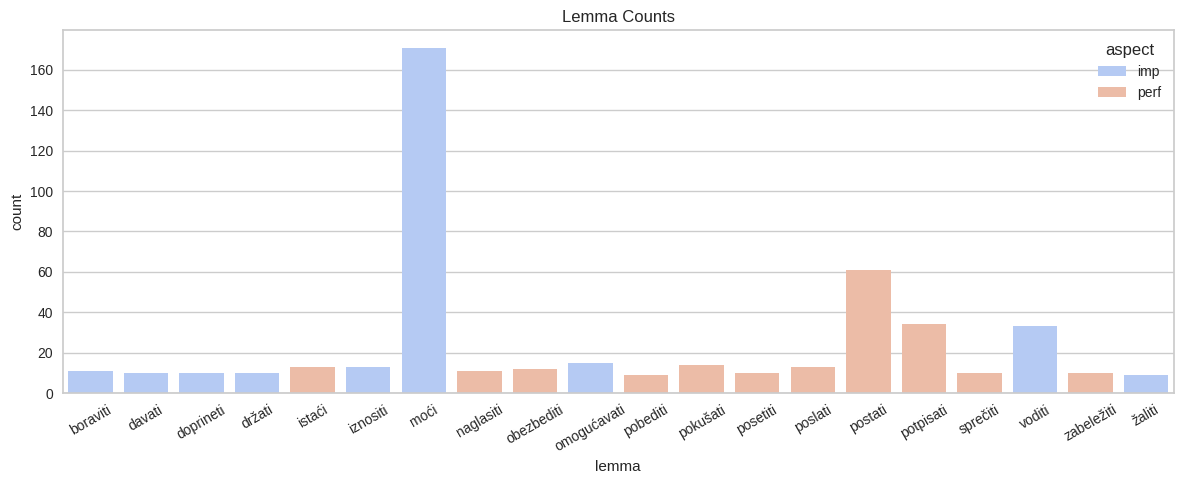

In [24]:
plot_freqs(test_df_unkn, "lemma", "aspect")

In [25]:
y_test_unkn = test_df_unkn[target_vars]
X_test_unkn = test_df_unkn.drop(target_vars, axis=1)
X_test_unkn.shape, y_test_unkn.shape

((550, 32), (550, 2))

In [26]:
X_train, X_test_holdout, y_train, y_test_holdout = train_test_split(
    train_df.drop(target_vars, axis=1),
    train_df[target_vars],
    test_size=0.1247,
    random_state=RANDOM_STATE,
    shuffle=True
)
X_train.shape, X_test_holdout.shape, y_train.shape, y_test_holdout.shape

((3859, 32), (550, 32), (3859, 2), (550, 2))

### Наивный эксперимент: категориальные фичи

In [27]:
X_train_naieve, X_test_holdout_naieve, X_test_unkn_naieve = one_hot_encode(
    X_train[grapheme_vars + grammar_vars],
    X_test_holdout[grapheme_vars + grammar_vars],
    X_test_unkn[grapheme_vars + grammar_vars],
)

In [28]:
X_train_naieve.shape, X_test_holdout_naieve.shape, X_test_unkn_naieve.shape

((3859, 166), (550, 166), (550, 166))


--- Naieve categorical: LGBMClassifier ---
 

F1 weighted (Holdout): 0.973 

F1 weighted (Unknown): 0.624 

CV F1: 0.967 

Holdout confusion matrix 

[[266  10]
 [  5 269]] 

Unknown confusion matrix 

[[171 134]
 [ 73 172]] 

Holdout report: 

              precision    recall  f1-score   support

         imp       0.98      0.96      0.97       276
        perf       0.96      0.98      0.97       274

    accuracy                           0.97       550
   macro avg       0.97      0.97      0.97       550
weighted avg       0.97      0.97      0.97       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.70      0.56      0.62       305
        perf       0.56      0.70      0.62       245

    accuracy                           0.62       550
   macro avg       0.63      0.63      0.62       550
weighted avg       0.64      0.62      0.62       550
 



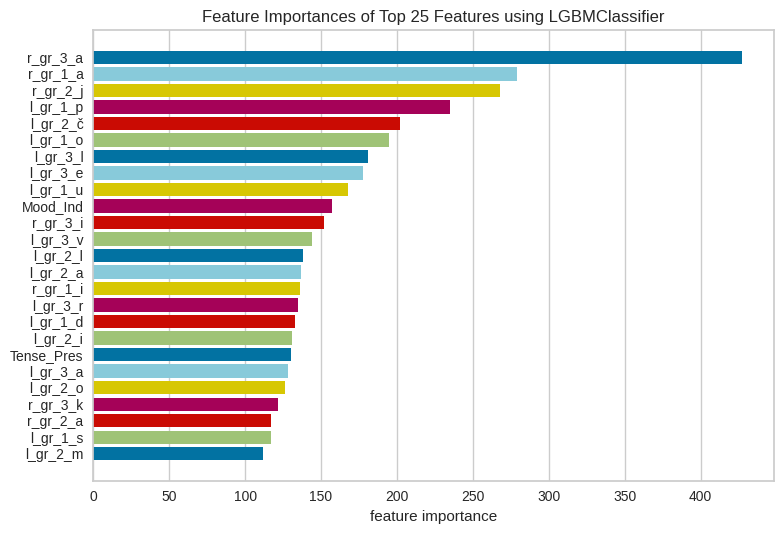

In [29]:
experiment(
    "Naieve categorical",
    "---",
    lambda: LGBMClassifier(verbose=-1, random_state=RANDOM_STATE),
    X_train_naieve,
    X_test_holdout_naieve,
    X_test_unkn_naieve,
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    log=None,
    report=True,
    fi=True,
    cv=True,
    confusion=True,
)

### Модели

In [30]:
get_regression = lambda: LogisticRegression(
    max_iter=200
)

get_dt = lambda: DecisionTreeClassifier(
    random_state=RANDOM_STATE
)

get_lgbm = lambda: LGBMClassifier(
    random_state=RANDOM_STATE,
    verbose=-1
)

get_nn = lambda: MLPClassifier(
    random_state=RANDOM_STATE,
    hidden_layer_sizes=(100, 50, 25),
    alpha=0.0001,
    max_iter=200
)

models = [get_regression, get_dt, get_lgbm, get_nn]

In [31]:
experiments = [
    lambda model: experiment(
        "all categorical",
        "Naieve",
        model,
        *one_hot_encode(
            X_train[grapheme_vars + grammar_vars],
            X_test_holdout[grapheme_vars + grammar_vars],
            X_test_unkn[grapheme_vars + grammar_vars],
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "all categorical PCA",
        "Naieve",
        model,
        *onehot_and_pca(
            20,
            X_train[grapheme_vars + grammar_vars],
            X_test_holdout[grapheme_vars + grammar_vars],
            X_test_unkn[grapheme_vars + grammar_vars],
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
]

In [32]:
for e in experiments:
    for model in models:
        e(model)


--- all categorical: LogisticRegression ---
 

F1 weighted (Holdout): 0.911 

F1 weighted (Unknown): 0.835 

CV F1: 0.906 


--- all categorical: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.956 

F1 weighted (Unknown): 0.715 

CV F1: 0.949 


--- all categorical: LGBMClassifier ---
 

F1 weighted (Holdout): 0.973 

F1 weighted (Unknown): 0.624 

CV F1: 0.967 


--- all categorical: MLPClassifier ---
 

F1 weighted (Holdout): 0.967 

F1 weighted (Unknown): 0.666 

CV F1: 0.961 


--- all categorical PCA: LogisticRegression ---
 

F1 weighted (Holdout): 0.798 

F1 weighted (Unknown): 0.717 

CV F1: 0.794 


--- all categorical PCA: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.874 

F1 weighted (Unknown): 0.583 

CV F1: 0.868 


--- all categorical PCA: LGBMClassifier ---
 

F1 weighted (Holdout): 0.907 

F1 weighted (Unknown): 0.748 

CV F1: 0.903 


--- all categorical PCA: MLPClassifier ---
 

F1 weighted (Holdout): 0.915 

F1 weighted (Unknown): 0.697 

CV F1: 0.

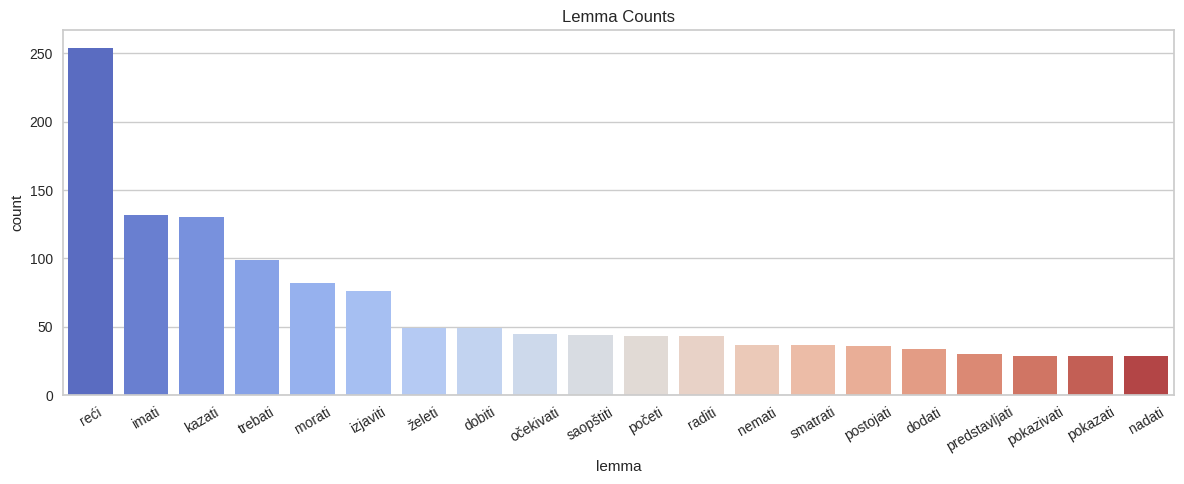

In [33]:
plot_freqs(X_train, "lemma")

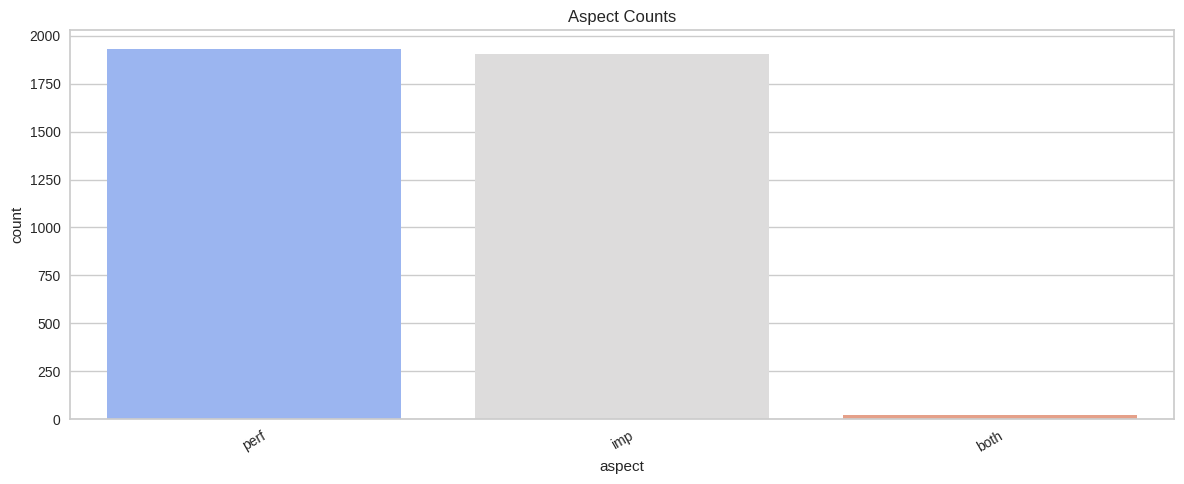

In [34]:
plot_freqs(y_train, "aspect")

### Эксперименты с графемами

In [35]:
X_train_graphemes          = X_train         [grapheme_vars]
# X_train_resample_graphemes = X_train_resample[grapheme_vars]
X_test_holdout_graphemes   = X_test_holdout  [grapheme_vars]
X_test_unkn_graphemes      = X_test_unkn     [grapheme_vars]

X_train_graphemes.head()

,l_gr_1,l_gr_2,l_gr_3,r_gr_1,r_gr_2,r_gr_3
1898,o,d,r,i,l,a
3998,s,p,r,e,d,e
2987,p,o,š,e,j,u
4256,u,b,i,o,i,b
4506,u,č,e,a,l,a


In [36]:
X_train_graphemes_2 = X_train_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
# X_train_resample_graphemes_2 = X_train_resample_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_test_holdout_graphemes_2 = X_test_holdout_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_test_unkn_graphemes_2 = X_test_unkn_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)

X_train_graphemes_2.head()

,l_gr_1,l_gr_2,r_gr_1,r_gr_2
1898,o,d,i,l
3998,s,p,e,d
2987,p,o,e,j
4256,u,b,o,i
4506,u,č,a,l


In [37]:
X_train_graphemes_1 = X_train_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
# X_train_resample_graphemes_1 = X_train_resample_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_test_holdout_graphemes_1 = X_test_holdout_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_test_unkn_graphemes_1 = X_test_unkn_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)

X_train_graphemes_1.head()

,l_gr_1,r_gr_1
1898,o,i
3998,s,e
2987,p,e
4256,u,o
4506,u,a


In [38]:
X_train_sufs = pd.DataFrame()
X_test_holdout_sufs = pd.DataFrame()
X_test_unkn_sufs = pd.DataFrame()

X_train_sufs["pref"] = X_train_graphemes["l_gr_1"] + X_train_graphemes["l_gr_2"] + X_train_graphemes["l_gr_3"]
X_train_sufs["suf"] = X_train_graphemes["r_gr_1"] + X_train_graphemes["r_gr_2"] + X_train_graphemes["r_gr_3"]

X_test_holdout_sufs["pref"] = X_test_holdout_graphemes["l_gr_1"] + X_test_holdout_graphemes["l_gr_2"] + X_test_holdout_graphemes["l_gr_3"]
X_test_holdout_sufs["suf"] = X_test_holdout_graphemes["r_gr_1"] + X_test_holdout_graphemes["r_gr_2"] + X_test_holdout_graphemes["r_gr_3"]

X_test_unkn_sufs["pref"] = X_test_unkn_graphemes["l_gr_1"] + X_test_unkn_graphemes["l_gr_2"] + X_test_unkn_graphemes["l_gr_3"]
X_test_unkn_sufs["suf"] = X_test_unkn_graphemes["r_gr_1"] + X_test_unkn_graphemes["r_gr_2"] + X_test_unkn_graphemes["r_gr_3"]

X_train_sufs.head()

,pref,suf
1898,odr,ila
3998,spr,ede
2987,poš,eju
4256,ubi,oib
4506,uče,ala


In [39]:
X_train_sufs.nunique()

pref    205
suf     250
dtype: int64

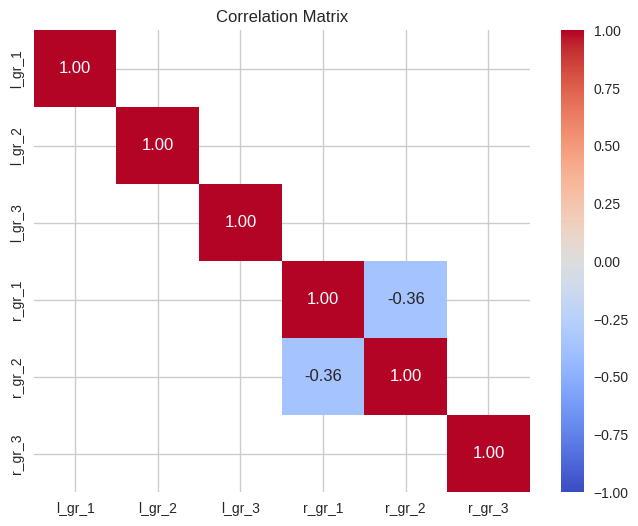

In [40]:
plot_corr(X_train_graphemes)

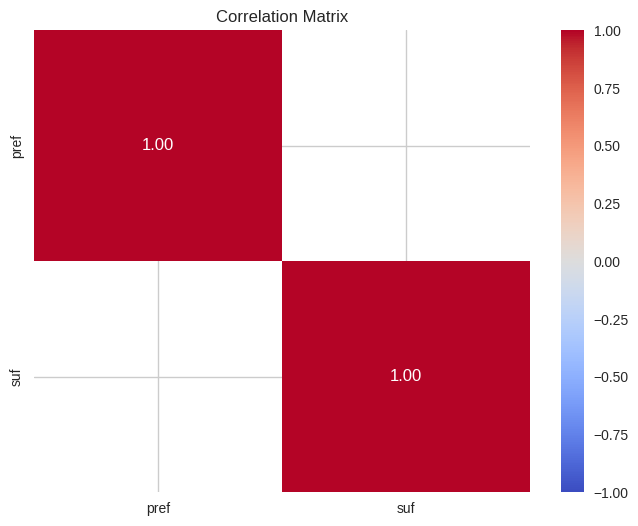

In [41]:
plot_corr(X_train_sufs)

In [42]:
experiments = [
    lambda model: experiment(
        "6_graphemes",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_graphemes,
            X_test_holdout_graphemes,
            X_test_unkn_graphemes,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "4_graphemes",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_graphemes_2,
            X_test_holdout_graphemes_2,
            X_test_unkn_graphemes_2,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "2_graphemes",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_graphemes_1,
            X_test_holdout_graphemes_1,
            X_test_unkn_graphemes_1,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "sufs",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_sufs,
            X_test_holdout_sufs,
            X_test_unkn_sufs,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),

    lambda model: experiment(
        "6_graphemes PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes,
            X_test_holdout_graphemes,
            X_test_unkn_graphemes,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
    lambda model: experiment(
        "4_graphemes PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes_2,
            X_test_holdout_graphemes_2,
            X_test_unkn_graphemes_2,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
    lambda model: experiment(
        "2_graphemes PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes_1,
            X_test_holdout_graphemes_1,
            X_test_unkn_graphemes_1,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
    lambda model: experiment(
        "sufs PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_sufs,
            X_test_holdout_sufs,
            X_test_unkn_sufs,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
]

In [43]:
# 6 min 20 sec
for e in experiments:
    for model in models:
        e(model)


--- 6_graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.876 

F1 weighted (Unknown): 0.811 

CV F1: 0.893 


--- 6_graphemes: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.953 

F1 weighted (Unknown): 0.605 

CV F1: 0.957 


--- 6_graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.965 

F1 weighted (Unknown): 0.650 

CV F1: 0.970 


--- 6_graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.962 

F1 weighted (Unknown): 0.734 

CV F1: 0.972 


--- 4_graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.845 

F1 weighted (Unknown): 0.882 

CV F1: 0.867 


--- 4_graphemes: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.913 

F1 weighted (Unknown): 0.838 

CV F1: 0.909 


--- 4_graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.922 

F1 weighted (Unknown): 0.806 

CV F1: 0.915 


--- 4_graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.922 

F1 weighted (Unknown): 0.815 

CV F1: 0.919 


--- 2_graphemes: LogisticRegression ---
 

In [44]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
0,all categorical,Naieve,LogisticRegression,False,0.906,0.911,0.835
1,all categorical,Naieve,DecisionTreeClassifier,False,0.949,0.956,0.715
2,all categorical,Naieve,LGBMClassifier,False,0.967,0.973,0.624
3,all categorical,Naieve,MLPClassifier,False,0.961,0.967,0.666
4,all categorical PCA,Naieve,LogisticRegression,True,0.794,0.798,0.717


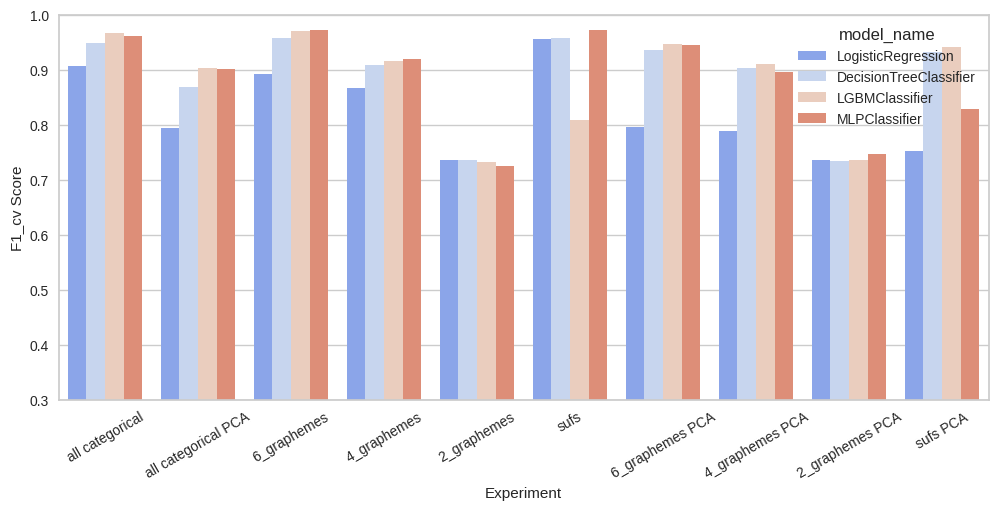

In [45]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

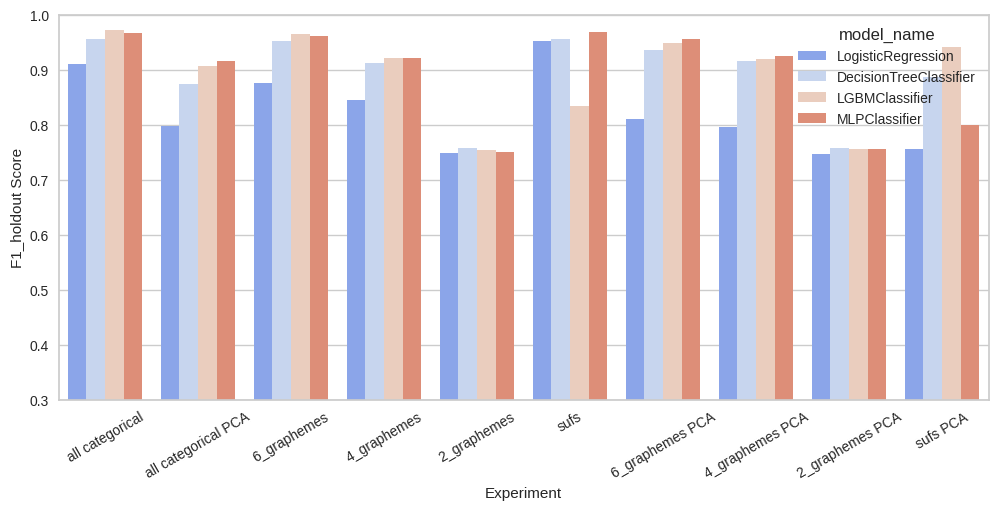

In [46]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

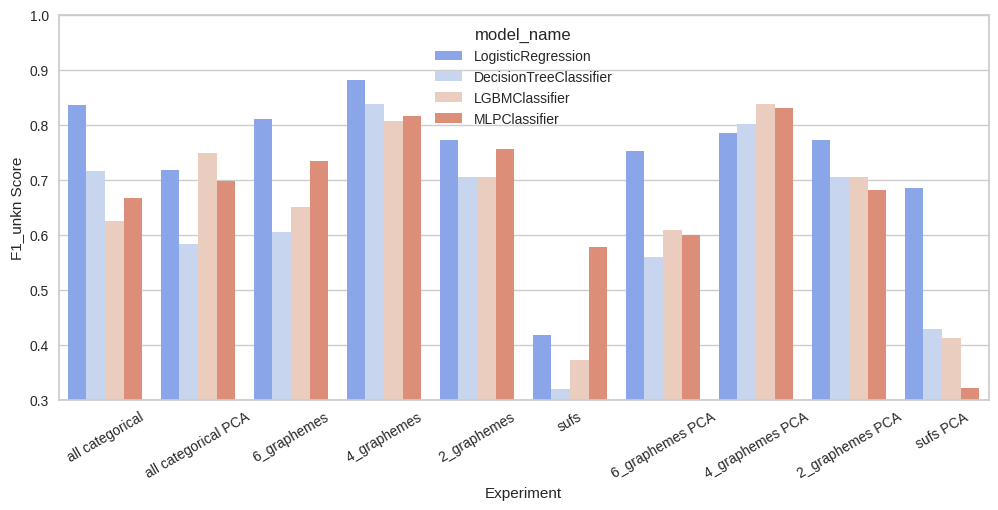

In [47]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [48]:
scores_df.loc[scores_df["F1_unkn"].idxmax()]

experiment_name            4_graphemes
experiment_group             Graphemes
model_name          LogisticRegression
PCA                              False
F1_cv                            0.867
F1_holdout                       0.845
F1_unkn                          0.882
Name: 12, dtype: object

In [49]:
X_train_graphemes_2_oh, X_test_holdout_graphemes_2_oh, X_test_unkn_graphemes_2_oh = one_hot_encode(
    X_train_graphemes_2,
    X_test_holdout_graphemes_2,
    X_test_unkn_graphemes_2,
)

In [50]:
# param_grid = {
#     "penalty"     : ["elasticnet"],
#     "C"           : [0.001, 0.01, 0.1, 1, 10, 100],
#     "solver"      : ["saga"],
#     "max_iter"    : [100, 200, 500],
#     "class_weight": [None, "balanced"],
#     "l1_ratio"    : [0.0, 0.1, 0.5, 0.9, 1.0],
#     "verbose"     : [0]
# }

In [51]:
# grid_search = GridSearchCV(
#     LogisticRegression(),
#     param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1,
#     verbose=0
# )
# grid_search.fit(X_train_graphemes_2_oh, y_train["aspect"])
# grid_search.best_score_

In [52]:
# best_params = grid_search.best_params_
best_params = {'C': 10,
 'class_weight': None,
 'l1_ratio': 0.1,
 'max_iter': 100,
 'penalty': 'elasticnet',
 'solver': 'saga',
 'verbose': 0}


--- 2_graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.851 

F1 weighted (Unknown): 0.884 

CV F1: 0.871 

Holdout confusion matrix 

[[  0   0   0]
 [  0 227  49]
 [  2  32 240]] 

Unknown confusion matrix 

[[271  34]
 [ 30 215]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.00      1.00      0.00         0
         imp       0.88      0.82      0.85       276
        perf       0.83      0.88      0.85       274

    accuracy                           0.85       550
   macro avg       0.57      0.90      0.57       550
weighted avg       0.85      0.85      0.85       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.90      0.89      0.89       305
        perf       0.86      0.88      0.87       245

    accuracy                           0.88       550
   macro avg       0.88      0.88      0.88       550
weighted avg       0.88      0.88      0.88       550
 



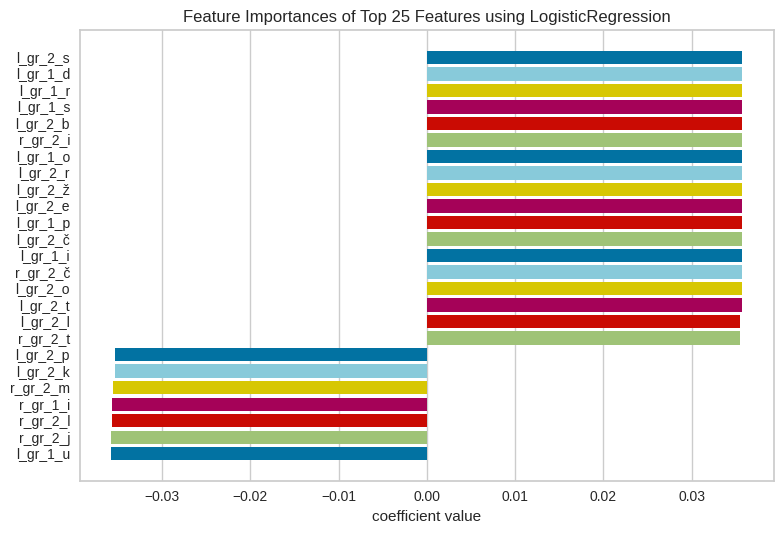

(None,)

In [53]:
experiment(
    "2_graphemes",
    "---",
    lambda: LogisticRegression(**best_params),
    X_train_graphemes_2_oh,
    X_test_holdout_graphemes_2_oh,
    X_test_unkn_graphemes_2_oh,
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
),

### Эксперименты с грамматикой

In [54]:
X_train_grammar = X_train[grammar_vars]
X_test_holdout_grammar = X_test_holdout[grammar_vars]
X_test_unkn_grammar = X_test_unkn[grammar_vars]

In [55]:
X_train_grammar.shape

(3859, 12)

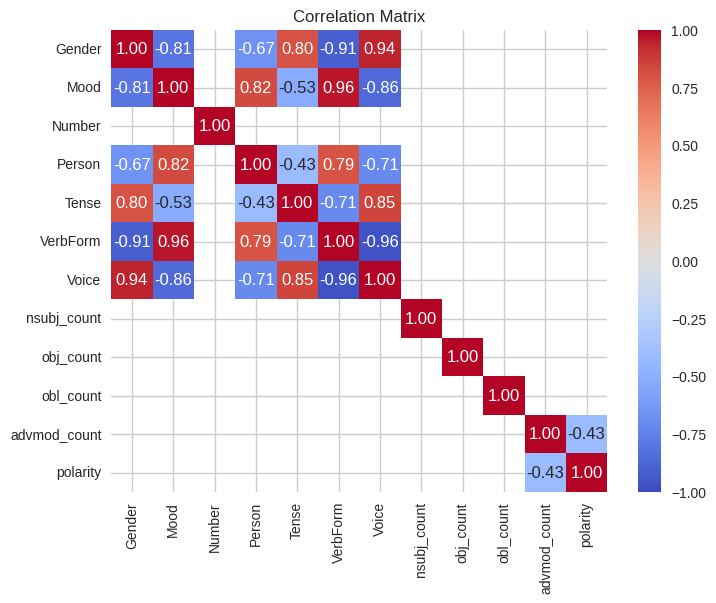

In [56]:
plot_corr(X_train_grammar)

In [57]:
categories = ["Gender", "Mood", "Number", "Person", "Tense", "VerbForm", "Voice"]

In [58]:
X_train_grammar_only_categories = X_train_grammar[categories]
X_test_holdout_grammar_only_categories = X_test_holdout_grammar[categories]
X_test_unkn_grammar_only_categories = X_test_unkn_grammar[categories]

X_train_grammar_no_categories = X_train_grammar.drop(categories, axis=1)
X_test_holdout_grammar_no_categories = X_test_holdout_grammar.drop(categories, axis=1)
X_test_unkn_grammar_no_categories = X_test_unkn_grammar.drop(categories, axis=1)

In [59]:
X_train_grammar_only_categories.shape, X_train_grammar_no_categories.shape

((3859, 7), (3859, 5))

In [60]:
experiments = [
    lambda model: experiment(
        "all grammar",
        "Grammar",
        model,
        *one_hot_encode(
            X_train_grammar,
            X_test_holdout_grammar,
            X_test_unkn_grammar,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "only categories grammar",
        "Grammar",
        model,
        *one_hot_encode(
            X_train_grammar_only_categories,
            X_test_holdout_grammar_only_categories,
            X_test_unkn_grammar_only_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "no categories grammar",
        "Grammar",
        model,
        *one_hot_encode(
            X_train_grammar_no_categories,
            X_test_holdout_grammar_no_categories,
            X_test_unkn_grammar_no_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "all grammar PCA",
        "Grammar",
        model,
        *onehot_and_pca(
            6,
            X_train_grammar,
            X_test_holdout_grammar,
            X_test_unkn_grammar,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
    lambda model: experiment(
        "only categories grammar PCA",
        "Grammar",
        model,
        *onehot_and_pca(
            6,
            X_train_grammar_only_categories,
            X_test_holdout_grammar_only_categories,
            X_test_unkn_grammar_only_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
    lambda model: experiment(
        "no categories grammar PCA",
        "Grammar",
        model,
        *onehot_and_pca(
            6,
            X_train_grammar_no_categories,
            X_test_holdout_grammar_no_categories,
            X_test_unkn_grammar_no_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
]

In [61]:
# 3 min 20 sec
for e in experiments:
    for model in models:
        e(model)


--- all grammar: LogisticRegression ---
 

F1 weighted (Holdout): 0.780 

F1 weighted (Unknown): 0.691 

CV F1: 0.764 


--- all grammar: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.787 

F1 weighted (Unknown): 0.700 

CV F1: 0.765 


--- all grammar: LGBMClassifier ---
 

F1 weighted (Holdout): 0.787 

F1 weighted (Unknown): 0.700 

CV F1: 0.772 


--- all grammar: MLPClassifier ---
 

F1 weighted (Holdout): 0.785 

F1 weighted (Unknown): 0.699 

CV F1: 0.768 


--- only categories grammar: LogisticRegression ---
 

F1 weighted (Holdout): 0.787 

F1 weighted (Unknown): 0.693 

CV F1: 0.769 


--- only categories grammar: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.783 

F1 weighted (Unknown): 0.701 

CV F1: 0.772 


--- only categories grammar: LGBMClassifier ---
 

F1 weighted (Holdout): 0.783 

F1 weighted (Unknown): 0.701 

CV F1: 0.772 


--- only categories grammar: MLPClassifier ---
 

F1 weighted (Holdout): 0.783 

F1 weighted (Unknown): 0.701 

CV F1: 0.

In [62]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["Grammar"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
40,all grammar,Grammar,LogisticRegression,False,0.764,0.780,0.691
41,all grammar,Grammar,DecisionTreeClassifier,False,0.765,0.787,0.700
42,all grammar,Grammar,LGBMClassifier,False,0.772,0.787,0.700
43,all grammar,Grammar,MLPClassifier,False,0.768,0.785,0.699
44,only categories grammar,Grammar,LogisticRegression,False,0.769,0.787,0.693


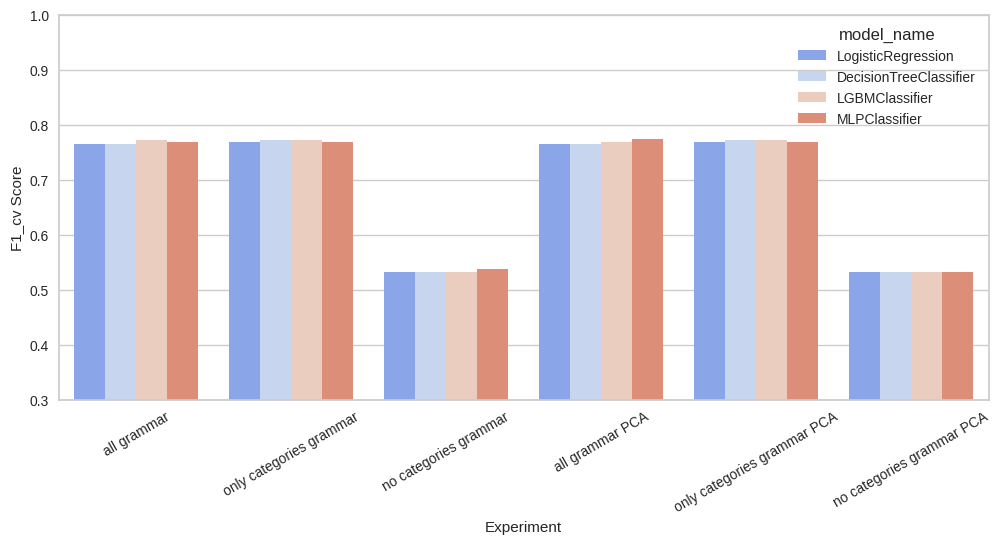

In [63]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

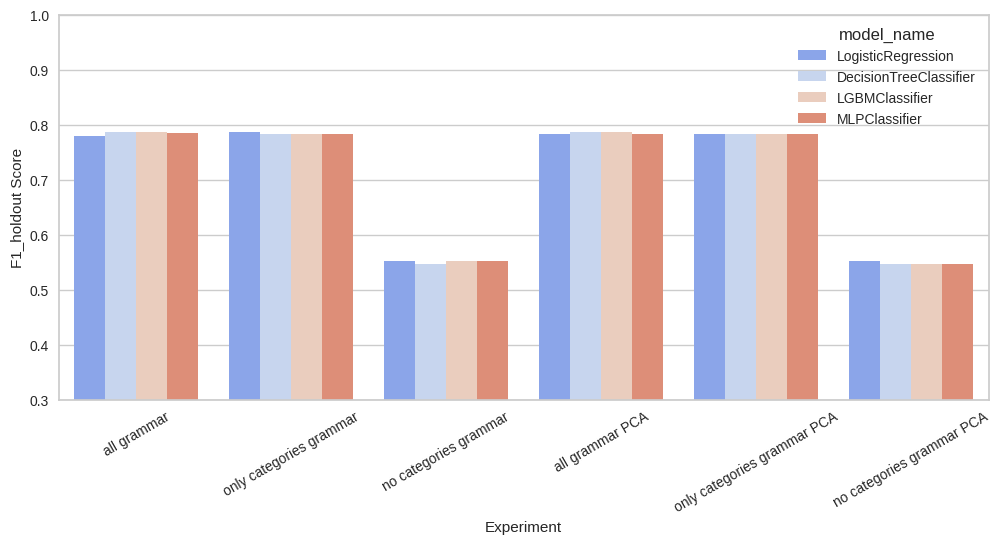

In [64]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

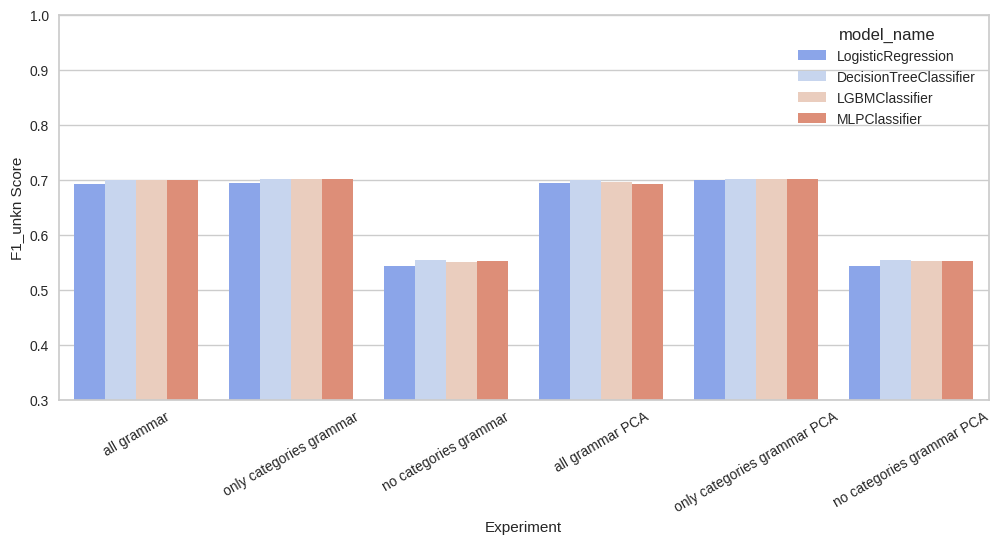

In [65]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)


--- only categories grammar: LGBMClassifier ---
 

F1 weighted (Holdout): 0.783 

F1 weighted (Unknown): 0.701 

Holdout confusion matrix 

[[226  50]
 [ 69 205]] 

Unknown confusion matrix 

[[198 107]
 [ 58 187]] 

Holdout report: 

              precision    recall  f1-score   support

         imp       0.77      0.82      0.79       276
        perf       0.80      0.75      0.78       274

    accuracy                           0.78       550
   macro avg       0.79      0.78      0.78       550
weighted avg       0.78      0.78      0.78       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.77      0.65      0.71       305
        perf       0.64      0.76      0.69       245

    accuracy                           0.70       550
   macro avg       0.70      0.71      0.70       550
weighted avg       0.71      0.70      0.70       550
 



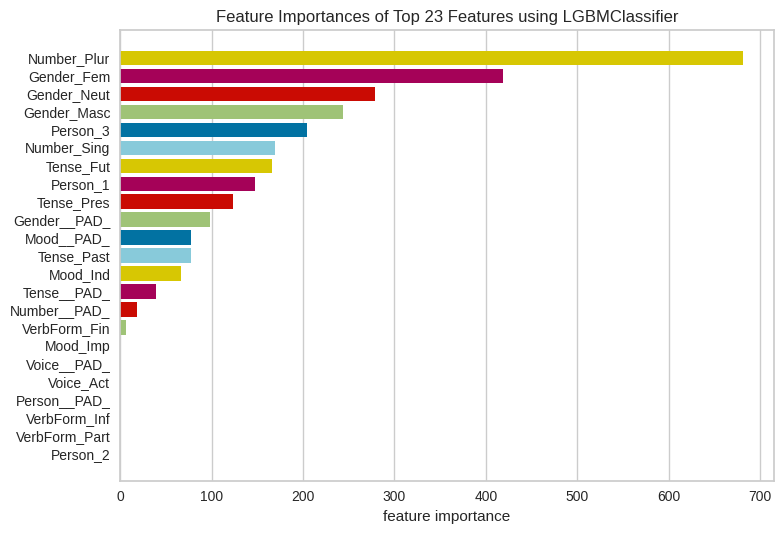

In [66]:
experiment(
    "only categories grammar",
    "---",
    get_lgbm,
    *one_hot_encode(
        X_train_grammar_only_categories,
        X_test_holdout_grammar_only_categories,
        X_test_unkn_grammar_only_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=False,
    log=None,
    fi=True,
    report=True,
    confusion=True
)


--- only categories grammar: LogisticRegression ---
 

F1 weighted (Holdout): 0.787 

F1 weighted (Unknown): 0.693 

Holdout confusion matrix 

[[223  53]
 [ 64 210]] 

Unknown confusion matrix 

[[195 110]
 [ 59 186]] 

Holdout report: 

              precision    recall  f1-score   support

         imp       0.78      0.81      0.79       276
        perf       0.80      0.77      0.78       274

    accuracy                           0.79       550
   macro avg       0.79      0.79      0.79       550
weighted avg       0.79      0.79      0.79       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.77      0.64      0.70       305
        perf       0.63      0.76      0.69       245

    accuracy                           0.69       550
   macro avg       0.70      0.70      0.69       550
weighted avg       0.71      0.69      0.69       550
 



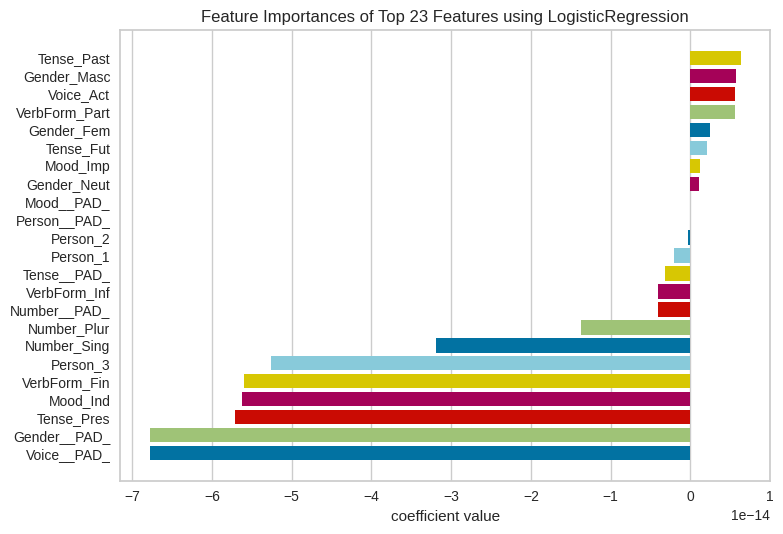

In [67]:
experiment(
    "only categories grammar",
    "---",
    get_regression,
    *one_hot_encode(
        X_train_grammar_only_categories,
        X_test_holdout_grammar_only_categories,
        X_test_unkn_grammar_only_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=False,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

In [68]:
# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "n_estimators": [30, 50, 100],
#     "max_depth": [3, 7, -1],
#     "num_leaves": [15, 30, 60, 120],
#     "subsample": [0.6, 0.8, 1.0],
#     "verbose": [-1]
# }

In [69]:
# X_train_grammar_only_categories_oh, X_test_holdout_grammar_only_categories_oh, X_test_unkn_grammar_only_categories_oh = one_hot_encode(
#     X_train_grammar_only_categories,
#     X_test_holdout_grammar_only_categories,
#     X_test_unkn_grammar_only_categories,
# )

In [70]:
# grid_search = GridSearchCV(
#     LGBMClassifier(),
#     param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1,
#     verbose=0
# )
# grid_search.fit(X_train_grammar_only_categories_oh, y_train["aspect"])
# grid_search.best_score_, grid_search.best_params_

### Совмещаем грамматику и графемы.

In [71]:
X_train_graphemes_2.columns.to_list()

['l_gr_1', 'l_gr_2', 'r_gr_1', 'r_gr_2']

In [72]:
X_train_graphemes_and_grammar_categories = X_train[
    X_train_graphemes_2.columns.to_list() + X_train_grammar_only_categories.columns.to_list()
]
X_train_graphemes_and_grammar_categories.head()

,l_gr_1,l_gr_2,r_gr_1,r_gr_2,Gender,Mood,Number,Person,Tense,VerbForm,Voice
1898,o,d,i,l,Masc,[PAD],Plur,[PAD],Past,Part,Act
3998,s,p,e,d,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
2987,p,o,e,j,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
4256,u,b,o,i,Masc,[PAD],Sing,[PAD],Past,Part,Act
4506,u,č,a,l,Fem,[PAD],Sing,[PAD],Past,Part,Act


In [73]:
X_test_holdout_graphemes_and_grammar_categories = X_test_holdout[
    X_train_graphemes_2.columns.to_list() + X_train_grammar_only_categories.columns.to_list()
]

X_test_unkn_graphemes_and_grammar_categories = X_test_unkn[
    X_train_graphemes_2.columns.to_list() + X_train_grammar_only_categories.columns.to_list()
]

In [74]:
# 1 min 30 sec
for model in models:

    experiment(
        "grammar and graphemes",
        "GrammarAndGraphemes",
        model,
        *one_hot_encode(
            X_train_graphemes_and_grammar_categories,
            X_test_holdout_graphemes_and_grammar_categories,
            X_test_unkn_graphemes_and_grammar_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    )

    experiment(
        "grammar and graphemes PCA",
        "GrammarAndGraphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes_and_grammar_categories,
            X_test_holdout_graphemes_and_grammar_categories,
            X_test_unkn_graphemes_and_grammar_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    )


--- grammar and graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.861 

F1 weighted (Unknown): 0.878 

CV F1: 0.869 


--- grammar and graphemes PCA: LogisticRegression ---
 

F1 weighted (Holdout): 0.813 

F1 weighted (Unknown): 0.715 

CV F1: 0.787 


--- grammar and graphemes: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.916 

F1 weighted (Unknown): 0.819 

CV F1: 0.916 


--- grammar and graphemes PCA: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.913 

F1 weighted (Unknown): 0.840 

CV F1: 0.909 


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.927 

F1 weighted (Unknown): 0.817 

CV F1: 0.916 


--- grammar and graphemes PCA: LGBMClassifier ---
 

F1 weighted (Holdout): 0.916 

F1 weighted (Unknown): 0.864 

CV F1: 0.910 


--- grammar and graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.924 

F1 weighted (Unknown): 0.798 

CV F1: 0.924 


--- grammar and graphemes PCA: MLPClassifier ---
 

F1 weighted (Holdout): 

In [75]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["GrammarAndGraphemes", "Naieve"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
0,all categorical,Naieve,LogisticRegression,False,0.906,0.911,0.835
1,all categorical,Naieve,DecisionTreeClassifier,False,0.949,0.956,0.715
2,all categorical,Naieve,LGBMClassifier,False,0.967,0.973,0.624
3,all categorical,Naieve,MLPClassifier,False,0.961,0.967,0.666
4,all categorical PCA,Naieve,LogisticRegression,True,0.794,0.798,0.717


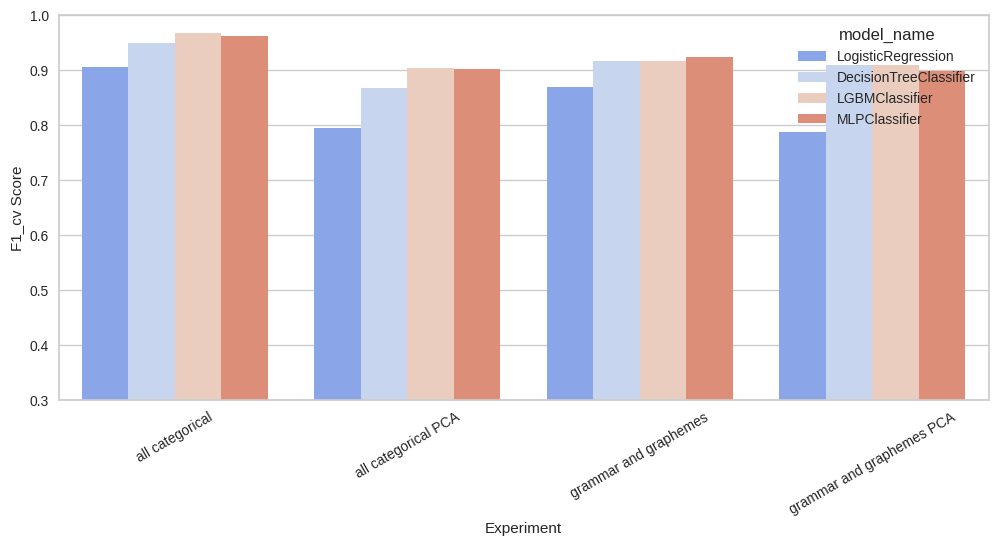

In [76]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

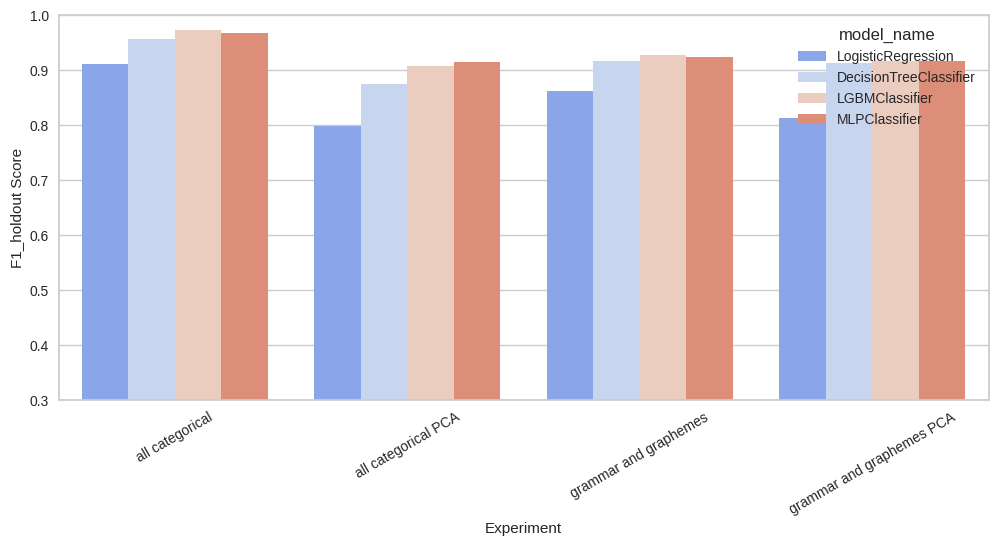

In [77]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

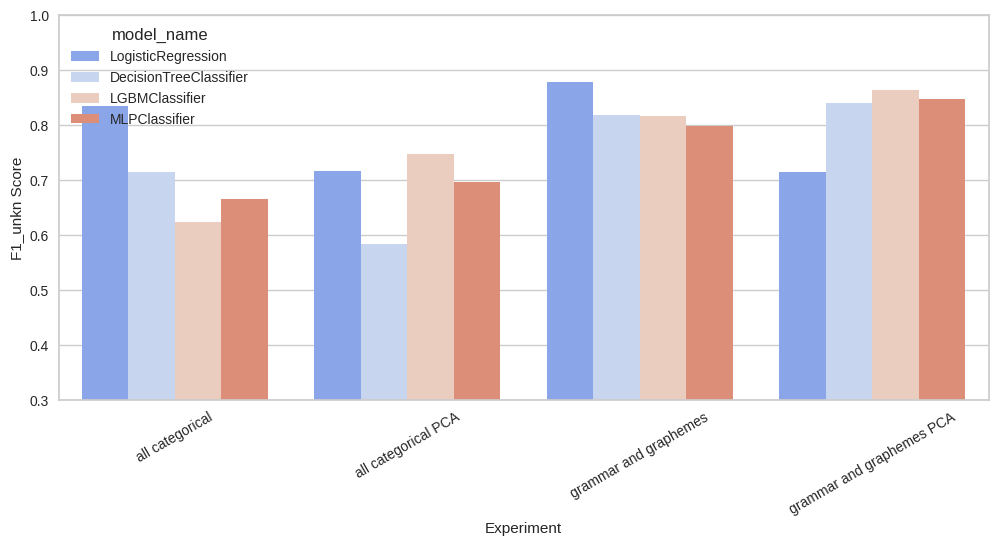

In [78]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.927 

F1 weighted (Unknown): 0.817 

CV F1: 0.916 

Holdout confusion matrix 

[[  0   0   0]
 [  0 249  27]
 [  2  12 260]] 

Unknown confusion matrix 

[[247  58]
 [ 43 202]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.00      1.00      0.00         0
         imp       0.95      0.90      0.93       276
        perf       0.91      0.95      0.93       274

    accuracy                           0.93       550
   macro avg       0.62      0.95      0.62       550
weighted avg       0.93      0.93      0.93       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.85      0.81      0.83       305
        perf       0.78      0.82      0.80       245

    accuracy                           0.82       550
   macro avg       0.81      0.82      0.82       550
weighted avg       0.82      0.82      0.82       550
 

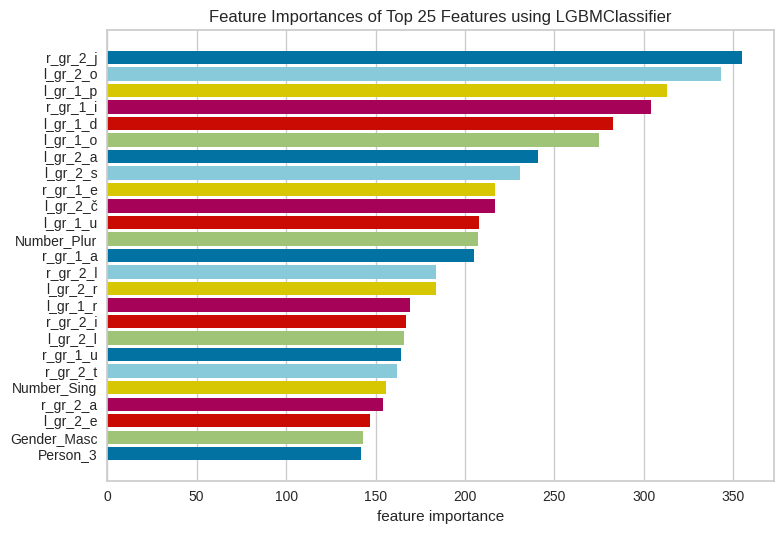

In [79]:
experiment(
    "grammar and graphemes",
    "---",
    get_lgbm,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.885 

F1 weighted (Unknown): 0.759 

CV F1: 0.876 

Holdout confusion matrix 

[[  0   0   0]
 [  0 240  36]
 [  2  26 246]] 

Unknown confusion matrix 

[[225  80]
 [ 53 192]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.00      1.00      0.00         0
         imp       0.90      0.87      0.89       276
        perf       0.87      0.90      0.88       274

    accuracy                           0.88       550
   macro avg       0.59      0.92      0.59       550
weighted avg       0.89      0.88      0.89       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.81      0.74      0.77       305
        perf       0.71      0.78      0.74       245

    accuracy                           0.76       550
   macro avg       0.76      0.76      0.76       550
weighted avg       0.76      0.76      0.76       550
 

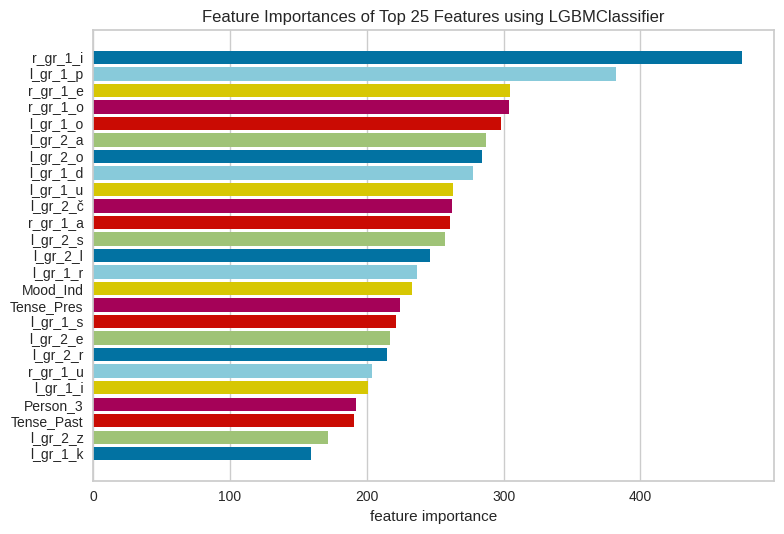

In [80]:
experiment(
    "grammar and graphemes",
    "---",
    get_lgbm,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories.drop(["r_gr_2", "Number", "Gender"], axis=1),
        X_test_holdout_graphemes_and_grammar_categories.drop(["r_gr_2", "Number", "Gender"], axis=1),
        X_test_unkn_graphemes_and_grammar_categories.drop(["r_gr_2", "Number", "Gender"], axis=1),
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)


--- grammar and graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.861 

F1 weighted (Unknown): 0.878 

CV F1: 0.869 

Holdout confusion matrix 

[[  0   0   0]
 [  0 226  50]
 [  2  25 247]] 

Unknown confusion matrix 

[[268  37]
 [ 30 215]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.00      1.00      0.00         0
         imp       0.90      0.82      0.86       276
        perf       0.83      0.90      0.87       274

    accuracy                           0.86       550
   macro avg       0.58      0.91      0.57       550
weighted avg       0.87      0.86      0.86       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.90      0.88      0.89       305
        perf       0.85      0.88      0.87       245

    accuracy                           0.88       550
   macro avg       0.88      0.88      0.88       550
weighted avg       0.88      0.88      0.88       5

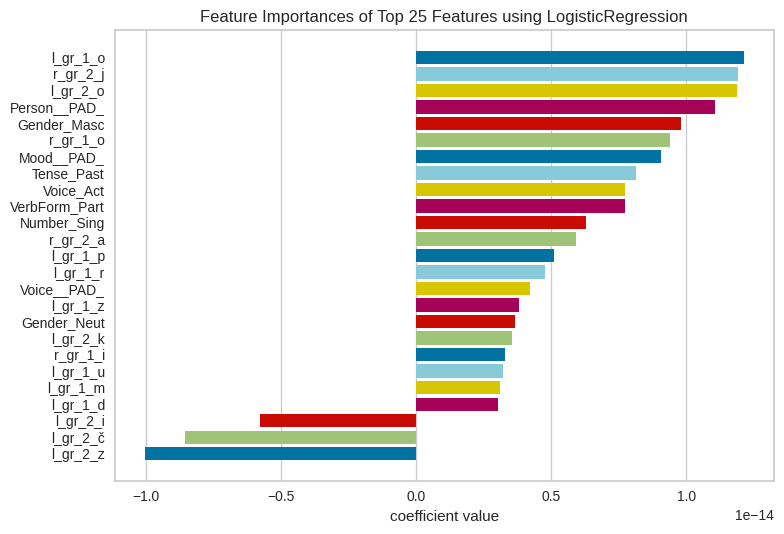

In [81]:
experiment(
    "grammar and graphemes",
    "---",
    get_regression,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

In [82]:
experiment(
    "grammar and graphemes",
    "---",
    get_nn,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    # fi=True,
    report=True,
    confusion=True
)


--- grammar and graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.924 

F1 weighted (Unknown): 0.798 

CV F1: 0.924 

Holdout confusion matrix 

[[  0   0   0]
 [  0 250  26]
 [  2  15 257]] 

Unknown confusion matrix 

[[250  55]
 [ 56 189]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.00      1.00      0.00         0
         imp       0.94      0.91      0.92       276
        perf       0.91      0.94      0.92       274

    accuracy                           0.92       550
   macro avg       0.62      0.95      0.62       550
weighted avg       0.93      0.92      0.92       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.82      0.82      0.82       305
        perf       0.77      0.77      0.77       245

    accuracy                           0.80       550
   macro avg       0.80      0.80      0.80       550
weighted avg       0.80      0.80      0.80       550
 


In [83]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [30, 50, 100],
    "max_depth": [3, 5, 7, -1],
    "num_leaves": [15, 30, 60, 100],
    "subsample": [0.6, 0.8, 1.0],
    "verbose": [-1]
}

In [84]:
X_graphemes_and_grammar_categories = one_hot_encode(
    X_train_graphemes_and_grammar_categories,
    X_test_holdout_graphemes_and_grammar_categories,
    X_test_unkn_graphemes_and_grammar_categories,
)

In [85]:
lgb = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=-1,
    num_leaves=15,
    subsample=0.6
)
lgb.fit(
    X_graphemes_and_grammar_categories[0], y_train["aspect"]
)

LGBMClassifier(num_leaves=15, subsample=0.6)

In [86]:
### Почему-то бежит 1 час
# grid_search = GridSearchCV(
#     LGBMClassifier(),
#     param_grid,
#     # cv=5,
#     scoring="accuracy",
#     n_jobs=-1,
#     verbose=0
# )
# grid_search.fit(X_graphemes_and_grammar_categories[0], y_train["aspect"])
# grid_search.best_score_, grid_search.best_params_

In [87]:
def custom_gridsearch(model:LGBMClassifier, param_grid, X_train, y_train, X_test, y_test):

    keys = param_grid.keys()
    value_combinations = product(*param_grid.values())

    best_metric = 0.0
    best_params = None

    for combination in tqdm(list(value_combinations)):
        params = {
            k: val
            for k, val
            in zip(keys, combination)
        }

        cur_model = model(**params)
        cur_model.fit(X_train, y_train)
        preds= cur_model.predict(X_test)

        f1_wtd = f1_score(y_test, preds, average="weighted")

        if f1_wtd > best_metric:
            best_metric = f1_wtd
            best_params = params

    return best_params, best_metric

In [88]:
best_params, metric = custom_gridsearch(
    LGBMClassifier,
    param_grid,
    X_graphemes_and_grammar_categories[0],
    y_train["aspect"],
    X_graphemes_and_grammar_categories[-1],
    y_test_unkn["aspect"]
)
best_params, metric

  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [01:37<00:00,  5.91it/s]


({'learning_rate': 0.1,
  'n_estimators': 50,
  'max_depth': 3,
  'num_leaves': 15,
  'subsample': 0.6,
  'verbose': -1},
 0.8820836705519292)

In [89]:
# best_params = {'learning_rate': 0.05,
#   'n_estimators': 50,
#   'max_depth': -1,
#   'num_leaves': 30,
#   'subsample': 0.6,
#   'verbose': -1}


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.845 

F1 weighted (Unknown): 0.882 

CV F1: 0.845 

Holdout confusion matrix 

[[  0   0   0]
 [  0 235  41]
 [  2  43 229]] 

Unknown confusion matrix 

[[265  40]
 [ 25 220]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.00      1.00      0.00         0
         imp       0.85      0.85      0.85       276
        perf       0.85      0.84      0.84       274

    accuracy                           0.84       550
   macro avg       0.56      0.90      0.56       550
weighted avg       0.85      0.84      0.85       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.91      0.87      0.89       305
        perf       0.85      0.90      0.87       245

    accuracy                           0.88       550
   macro avg       0.88      0.88      0.88       550
weighted avg       0.88      0.88      0.88       550
 

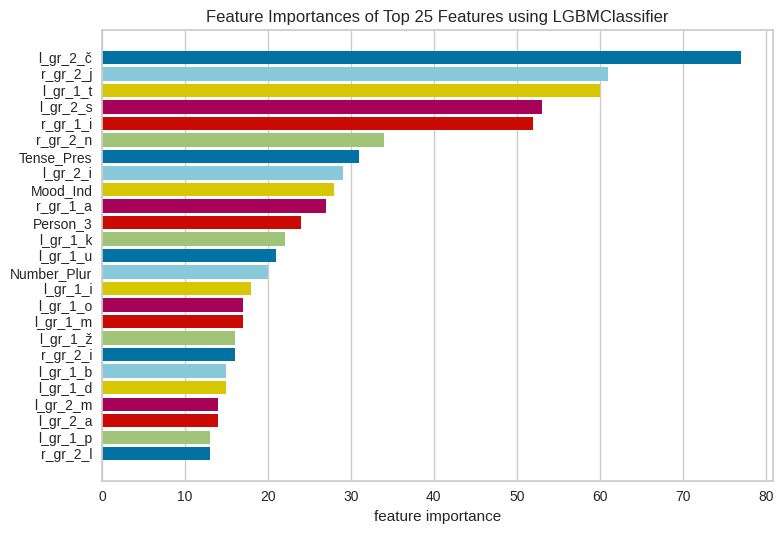

In [90]:
experiment(
    "grammar and graphemes",
    "---",
    lambda: LGBMClassifier(**best_params),
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

### Текстовые фичи

In [91]:
class Encoder:

    def __init__(self, path_to_model):
        self.model = Word2Vec.load(path_to_model)
        self.ndim = self.model.wv.word_vec("krastavac").shape[0]

    def encode(self, text: str):
        tokens = word_tokenize(text)

        vecs = [
            self.model.wv.word_vec(token)
            for token
            in tokens
            if token in self.model.wv.key_to_index
        ]

        if vecs:
            return np.mean(vecs, axis=0)
        else:
            return np.zeros((self.ndim,))


In [92]:
encoder = Encoder(str(Path.cwd() / "SrW2V" / "TeslaW2V"))

In [93]:
encoder.encode("Nisam bio")

array([ 8.47340345e-01, -1.24501288e-01,  4.86958170e+00, -1.34273803e+00,
       -2.97086954e+00,  3.71142268e+00,  2.43387508e+00,  3.85181069e+00,
       -2.95421219e+00,  3.34436417e-01, -1.58875257e-01, -1.58686471e+00,
       -1.28946507e+00, -3.01051617e-01,  9.45121050e-01,  1.77668595e+00,
        5.86993098e-01, -1.22962356e+00,  2.33354139e+00, -3.38673544e+00,
       -1.20569634e+00, -2.75937104e+00, -5.83984470e+00,  1.30355811e+00,
       -4.45962906e+00,  1.23837054e-01, -4.12644053e+00,  3.44431496e+00,
       -2.49842501e+00, -6.92725182e-03, -1.94456697e-01, -3.43638372e+00,
       -2.82443762e-02,  8.21025610e-01, -2.22832203e+00, -3.07466745e+00,
        2.21040154e+00,  8.69077206e-01,  1.93974113e+00,  1.94455415e-01,
        1.29528332e+00,  4.54815626e+00,  6.07638001e-01,  1.40939832e-01,
        4.75796402e-01,  3.91436172e+00, -1.04877102e+00,  5.56937504e+00,
       -4.74003887e+00,  4.52731252e-01, -3.81715775e+00, -4.98578358e+00,
       -3.72529936e+00,  

In [94]:
encoder.encode("alsdjhja akjdbha")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [95]:
X_train_words_encoded = [
    encoder.encode(word)
    for word
    in X_train["word"].values
]

X_test_holdout_words_encoded = [
    encoder.encode(word)
    for word
    in X_test_holdout["word"].values
]

X_test_unkn_words_encoded = [
    encoder.encode(word)
    for word
    in X_test_unkn["word"].values
]

X_train_lemmas_encoded = [
    encoder.encode(word)
    for word
    in X_train["lemma"].values
]

X_test_holdout_lemmas_encoded = [
    encoder.encode(word)
    for word
    in X_test_holdout["lemma"].values
]

X_test_unkn_lemmas_encoded = [
    encoder.encode(word)
    for word
    in X_test_unkn["lemma"].values
]

In [96]:
experiments = [
    lambda model: experiment(
        "word embeddings",
        "W2V",
        model,
        X_train_words_encoded,
        X_test_holdout_words_encoded,
        X_test_unkn_words_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "lemma embeddings",
        "W2V",
        model,
        X_train_lemmas_encoded,
        X_test_holdout_lemmas_encoded,
        X_test_unkn_lemmas_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word and lemma embeddings ",
        "W2V",
        model,
        X_train_lemmas_encoded + X_train_words_encoded,
        X_test_holdout_lemmas_encoded,
        X_test_unkn_lemmas_encoded,
        y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
        y_test_holdout["aspect"].values.tolist(),
        y_test_unkn["aspect"].values.tolist(),
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word and lemma embeddings many",
        "W2V",
        model,
        X_train_lemmas_encoded + X_train_words_encoded + X_train_words_encoded + X_train_words_encoded,
        X_test_holdout_lemmas_encoded,
        X_test_unkn_lemmas_encoded,
        y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
        y_test_holdout["aspect"].values.tolist(),
        y_test_unkn["aspect"].values.tolist(),
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings many",
        "W2V",
        model,
        X_train_words_encoded + X_train_words_encoded + X_train_words_encoded,
        X_test_holdout_words_encoded,
        X_test_unkn_words_encoded,
        y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
        y_test_holdout["aspect"].values.tolist(),
        y_test_unkn["aspect"].values.tolist(),
        cv=True,
        log=LOG,
    ),
]

In [97]:
for e in experiments:
    for model in models:
        e(model)


--- word embeddings: LogisticRegression ---
 

F1 weighted (Holdout): 0.965 

F1 weighted (Unknown): 0.767 

CV F1: 0.946 


--- word embeddings: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.951 

F1 weighted (Unknown): 0.747 

CV F1: 0.943 


--- word embeddings: LGBMClassifier ---
 

F1 weighted (Holdout): 0.987 

F1 weighted (Unknown): 0.918 

CV F1: 0.973 


--- word embeddings: MLPClassifier ---
 

F1 weighted (Holdout): 0.989 

F1 weighted (Unknown): 0.871 

CV F1: 0.982 


--- lemma embeddings: LogisticRegression ---
 

F1 weighted (Holdout): 1.000 

F1 weighted (Unknown): 0.556 

CV F1: 0.998 


--- lemma embeddings: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 1.000 

F1 weighted (Unknown): 0.738 

CV F1: 0.998 


--- lemma embeddings: LGBMClassifier ---
 

F1 weighted (Holdout): 1.000 

F1 weighted (Unknown): 0.597 

CV F1: 0.998 


--- lemma embeddings: MLPClassifier ---
 

F1 weighted (Holdout): 0.996 

F1 weighted (Unknown): 0.646 

CV F1: 0.998 


--- w

In [98]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["W2V"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
72,word embeddings,W2V,LogisticRegression,False,0.946,0.965,0.767
73,word embeddings,W2V,DecisionTreeClassifier,False,0.943,0.951,0.747
74,word embeddings,W2V,LGBMClassifier,False,0.973,0.987,0.918
75,word embeddings,W2V,MLPClassifier,False,0.982,0.989,0.871
76,lemma embeddings,W2V,LogisticRegression,False,0.998,1.000,0.556


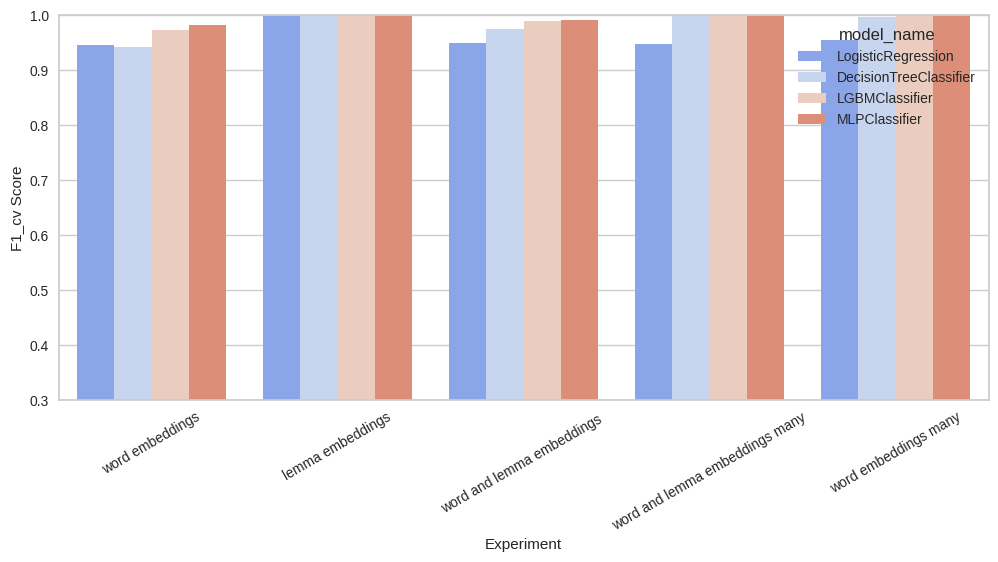

In [99]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

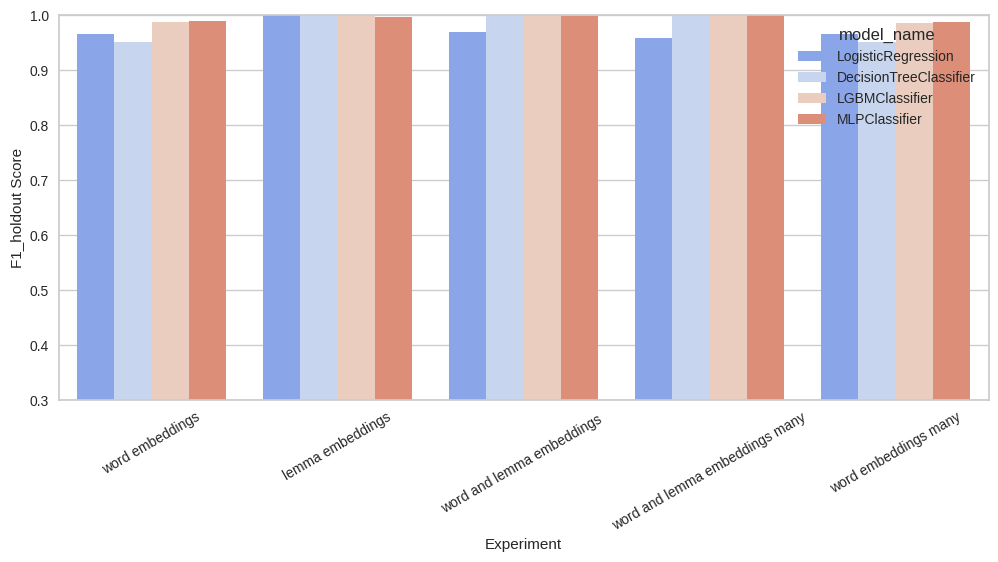

In [100]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

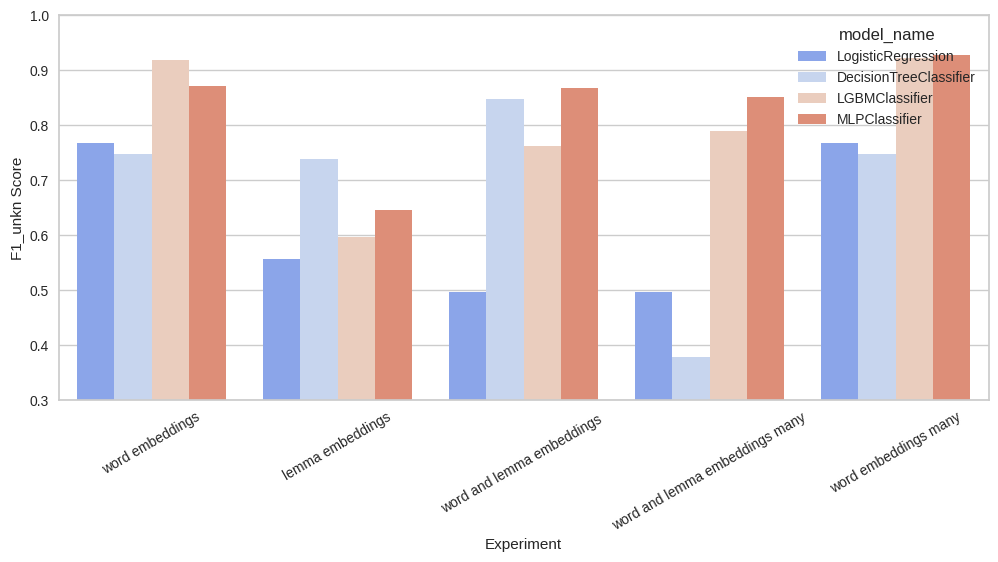

In [101]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [102]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [30, 50, 100],
    "max_depth": [3, 5, 7, -1],
    "num_leaves": [15, 30, 60, 100],
    "subsample": [0.6, 0.8, 1.0],
    "verbose": [-1]
}

In [103]:
best_params, metric = custom_gridsearch(
    LGBMClassifier,
    param_grid,
    X_train_words_encoded + X_train_words_encoded,
    y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
    X_test_unkn_words_encoded,
    y_test_unkn["aspect"].values.tolist(),
)
best_params, metric

100%|██████████| 432/432 [06:37<00:00,  1.09it/s]


({'learning_rate': 0.1,
  'n_estimators': 100,
  'max_depth': -1,
  'num_leaves': 15,
  'subsample': 0.6,
  'verbose': -1},
 0.9436685713209433)

In [104]:
# best_params = {'learning_rate': 0.1,
#   'n_estimators': 100,
#   'max_depth': 7,
#   'num_leaves': 30,
#   'subsample': 0.6,
#   'verbose': -1}


--- word embeddings: LGBMClassifier ---
 

F1 weighted (Holdout): 0.980 

F1 weighted (Unknown): 0.944 

CV F1: 0.994 

Holdout confusion matrix 

[[270   6]
 [  5 269]] 

Unknown confusion matrix 

[[288  17]
 [ 14 231]] 

Holdout report: 

              precision    recall  f1-score   support

         imp       0.98      0.98      0.98       276
        perf       0.98      0.98      0.98       274

    accuracy                           0.98       550
   macro avg       0.98      0.98      0.98       550
weighted avg       0.98      0.98      0.98       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.95      0.94      0.95       305
        perf       0.93      0.94      0.94       245

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550
 



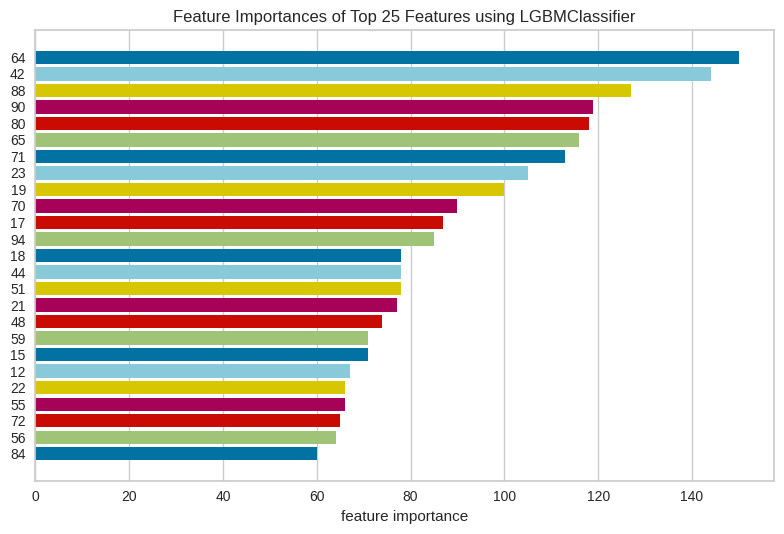

In [105]:
experiment(
    "word embeddings",
    "W2V",
    lambda: LGBMClassifier(**best_params),
    np.array(X_train_words_encoded + X_train_words_encoded),
    X_test_holdout_words_encoded,
    X_test_unkn_words_encoded,
    np.array(y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist()),
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

In [106]:
X_train_words_and_nsubj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["nsubj"]))
    for _, row
    in X_train.iterrows()
]

In [107]:
X_test_holdout_words_and_nsubj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["nsubj"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_nsubj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["nsubj"]))
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_obj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obj"]))
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_obj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obj"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_obj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obj"]))
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_obl_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obl"]))
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_obl_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obl"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_obl_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obl"]))
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_advmod_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["advmod"]))
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_advmod_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["advmod"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_advmod_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["advmod"]))
    for _, row
    in X_test_unkn.iterrows()
]

In [108]:
X_train_words_and_ctx_encoded = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

In [109]:
experiments = [
    lambda model: experiment(
        "word embeddings nsubj",
        "W2V_ext",
        model,
        X_train_words_and_nsubj_encoded,
        X_test_holdout_words_and_nsubj_encoded,
        X_test_unkn_words_and_nsubj_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings obj",
        "W2V_ext",
        model,
        X_train_words_and_obj_encoded,
        X_test_holdout_words_and_obj_encoded,
        X_test_unkn_words_and_obj_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings obl",
        "W2V_ext",
        model,
        X_train_words_and_obj_encoded,
        X_test_holdout_words_and_obl_encoded,
        X_test_unkn_words_and_obl_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings advmod",
        "W2V_ext",
        model,
        X_train_words_and_advmod_encoded,
        X_test_holdout_words_and_advmod_encoded,
        X_test_unkn_words_and_advmod_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx",
        "W2V_ext",
        model,
        X_train_words_and_ctx_encoded,
        X_test_holdout_words_and_ctx_encoded,
        X_test_unkn_words_and_ctx_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
]

In [110]:
for e in experiments:
    for model in models:
        e(model)


--- word embeddings nsubj: LogisticRegression ---
 

F1 weighted (Holdout): 0.962 

F1 weighted (Unknown): 0.783 

CV F1: 0.942 


--- word embeddings nsubj: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.954 

F1 weighted (Unknown): 0.743 

CV F1: 0.937 


--- word embeddings nsubj: LGBMClassifier ---
 

F1 weighted (Holdout): 0.989 

F1 weighted (Unknown): 0.909 

CV F1: 0.974 


--- word embeddings nsubj: MLPClassifier ---
 

F1 weighted (Holdout): 0.991 

F1 weighted (Unknown): 0.898 

CV F1: 0.971 


--- word embeddings obj: LogisticRegression ---
 

F1 weighted (Holdout): 0.960 

F1 weighted (Unknown): 0.770 

CV F1: 0.944 


--- word embeddings obj: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.946 

F1 weighted (Unknown): 0.795 

CV F1: 0.939 


--- word embeddings obj: LGBMClassifier ---
 

F1 weighted (Holdout): 0.989 

F1 weighted (Unknown): 0.922 

CV F1: 0.972 


--- word embeddings obj: MLPClassifier ---
 

F1 weighted (Holdout): 0.976 

F1 weighted (Unk

In [111]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["W2V_ext"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
92,word embeddings nsubj,W2V_ext,LogisticRegression,False,0.942,0.962,0.783
93,word embeddings nsubj,W2V_ext,DecisionTreeClassifier,False,0.937,0.954,0.743
94,word embeddings nsubj,W2V_ext,LGBMClassifier,False,0.974,0.989,0.909
95,word embeddings nsubj,W2V_ext,MLPClassifier,False,0.971,0.991,0.898
96,word embeddings obj,W2V_ext,LogisticRegression,False,0.944,0.960,0.770


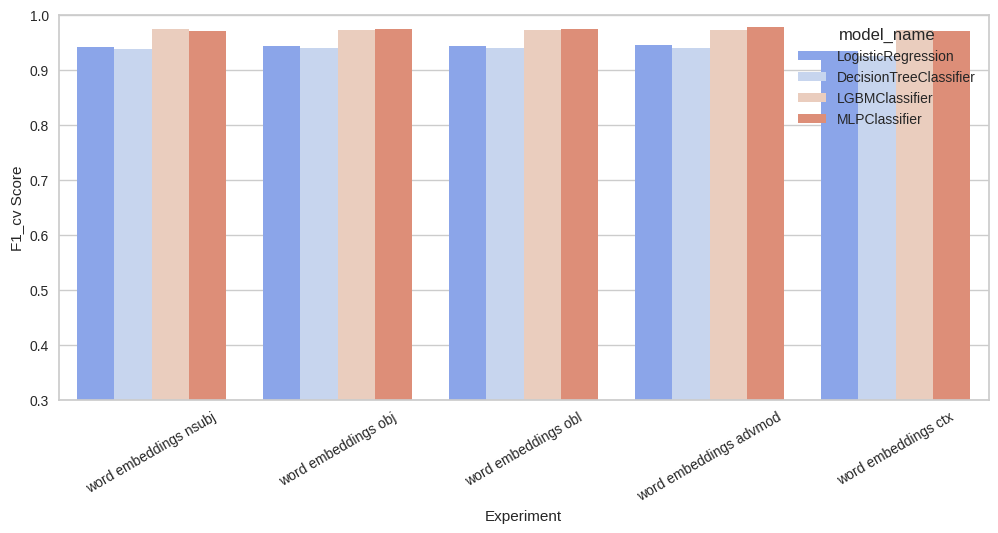

In [112]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

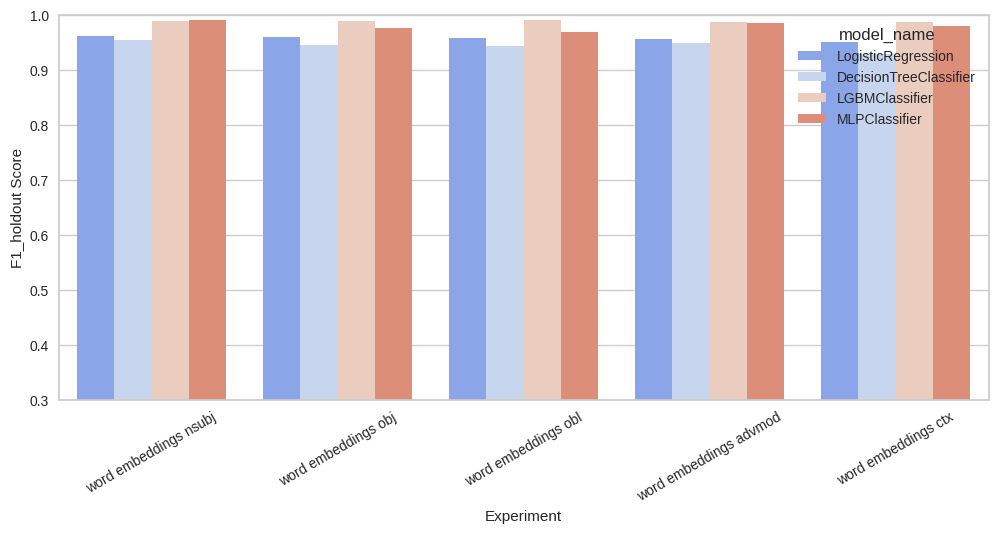

In [113]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

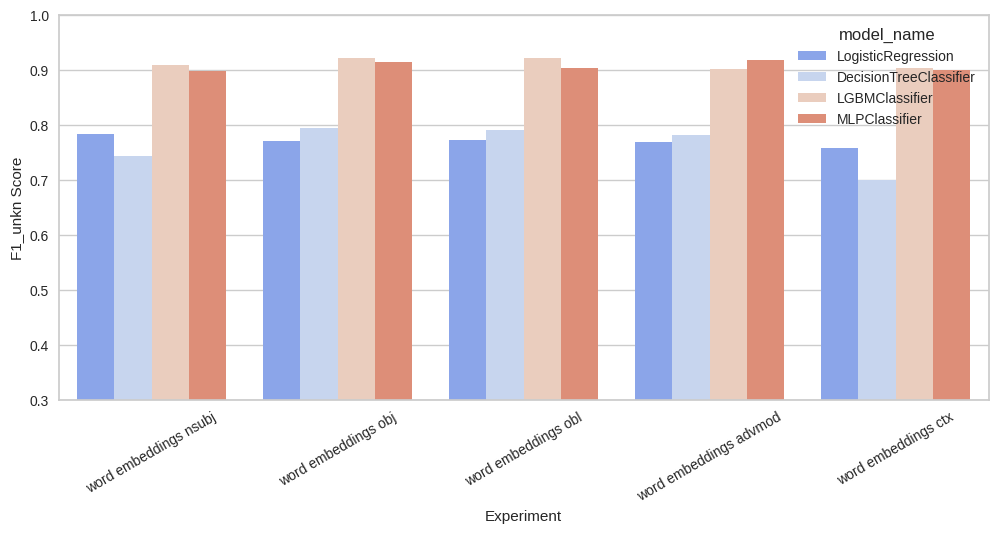

In [114]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [115]:
X_train_words_and_ctx_encoded_3 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_3 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_3 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_2 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_2 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_2 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_1 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_1"], row["r_tok_1"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_1 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_1"], row["r_tok_1"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_1 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_1"], row["r_tok_1"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

In [116]:
X_train_words_and_ctx_encoded_3_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
            )
         )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_3_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
            )
         )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_3_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
            )
         )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_2_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"],])
            )
         )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_2_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"],])
            )
         )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_2_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"],])
            )
         )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_1_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"],])
            )
         )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_1_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"],])
            )
         )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_1_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"],])
            )
         )
    )
    for _, row
    in X_test_unkn.iterrows()
]

In [117]:
experiments = [
    lambda model: experiment(
        "word embeddings ctx 3",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_3,
        X_test_holdout_words_and_ctx_encoded_3,
        X_test_unkn_words_and_ctx_encoded_3,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 2",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_2,
        X_test_holdout_words_and_ctx_encoded_2,
        X_test_unkn_words_and_ctx_encoded_2,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 1",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_1,
        X_test_holdout_words_and_ctx_encoded_1,
        X_test_unkn_words_and_ctx_encoded_1,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 3 split",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_3_split,
        X_test_holdout_words_and_ctx_encoded_3_split,
        X_test_unkn_words_and_ctx_encoded_3_split,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 2 split",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_2_split,
        X_test_holdout_words_and_ctx_encoded_2_split,
        X_test_unkn_words_and_ctx_encoded_2_split,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 1 split",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_1_split,
        X_test_holdout_words_and_ctx_encoded_1_split,
        X_test_unkn_words_and_ctx_encoded_1_split,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
]

In [118]:
for e in experiments:
    for model in models:
        e(model)


--- word embeddings ctx 3: LogisticRegression ---
 

F1 weighted (Holdout): 0.951 

F1 weighted (Unknown): 0.758 

CV F1: 0.934 


--- word embeddings ctx 3: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.929 

F1 weighted (Unknown): 0.700 

CV F1: 0.925 


--- word embeddings ctx 3: LGBMClassifier ---
 

F1 weighted (Holdout): 0.987 

F1 weighted (Unknown): 0.904 

CV F1: 0.972 


--- word embeddings ctx 3: MLPClassifier ---
 

F1 weighted (Holdout): 0.980 

F1 weighted (Unknown): 0.900 

CV F1: 0.971 


--- word embeddings ctx 2: LogisticRegression ---
 

F1 weighted (Holdout): 0.955 

F1 weighted (Unknown): 0.749 

CV F1: 0.937 


--- word embeddings ctx 2: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.947 

F1 weighted (Unknown): 0.715 

CV F1: 0.925 


--- word embeddings ctx 2: LGBMClassifier ---
 

F1 weighted (Holdout): 0.985 

F1 weighted (Unknown): 0.931 

CV F1: 0.972 


--- word embeddings ctx 2: MLPClassifier ---
 

F1 weighted (Holdout): 0.982 

F1 weigh

In [119]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["W2V_ext_ctx"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
112,word embeddings ctx 3,W2V_ext_ctx,LogisticRegression,False,0.934,0.951,0.758
113,word embeddings ctx 3,W2V_ext_ctx,DecisionTreeClassifier,False,0.925,0.929,0.700
114,word embeddings ctx 3,W2V_ext_ctx,LGBMClassifier,False,0.972,0.987,0.904
115,word embeddings ctx 3,W2V_ext_ctx,MLPClassifier,False,0.971,0.980,0.900
116,word embeddings ctx 2,W2V_ext_ctx,LogisticRegression,False,0.937,0.955,0.749


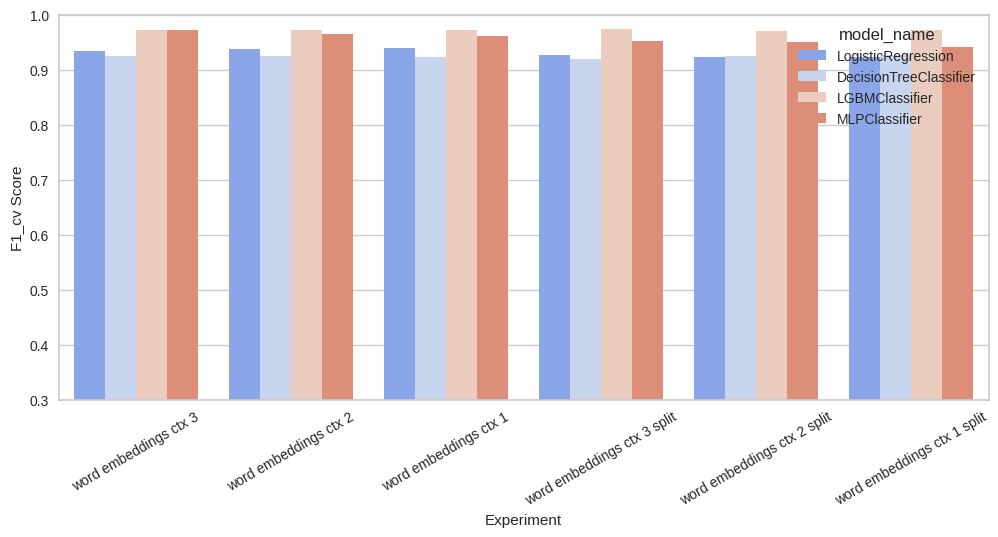

In [120]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

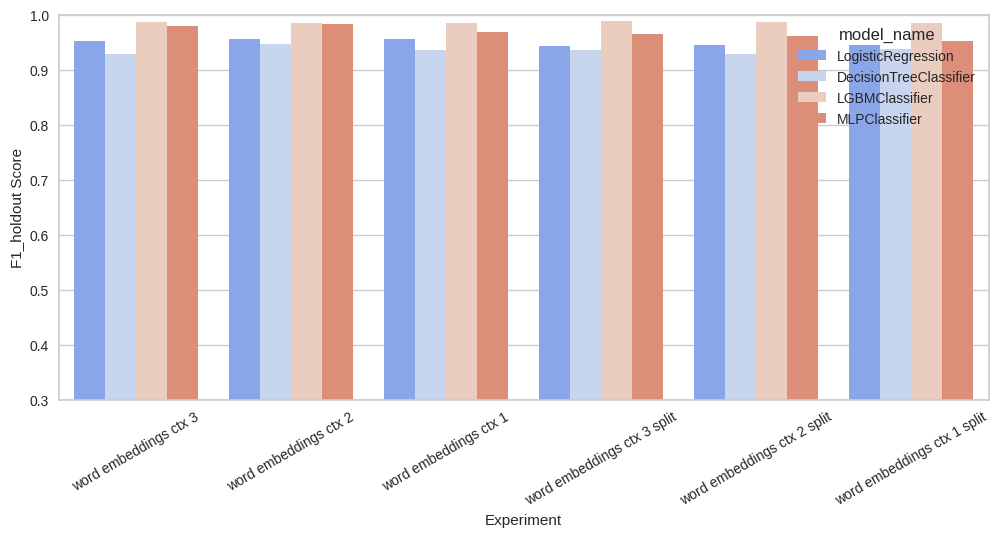

In [121]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

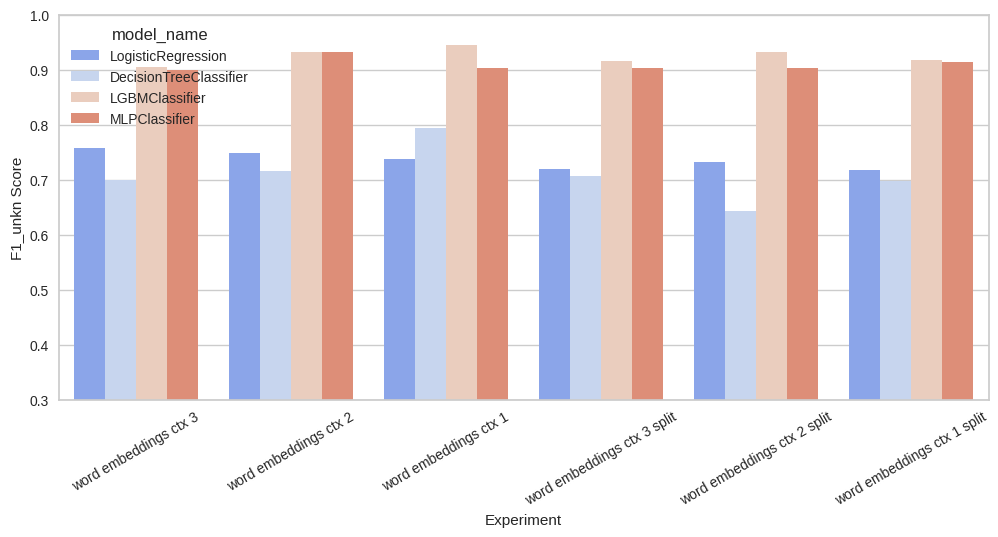

In [122]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [123]:
scores_df.loc[scores_df["F1_unkn"].idxmax()]

experiment_name     word embeddings ctx 1
experiment_group              W2V_ext_ctx
model_name                 LGBMClassifier
PCA                                 False
F1_cv                               0.971
F1_holdout                          0.985
F1_unkn                             0.944
Name: 122, dtype: object

In [124]:
param_grid = {
    "learning_rate": [0.05, 0.1],
    "n_estimators": [30, 50, 100],
    "max_depth": [3, 5, 7, -1],
    "num_leaves": [15, 30, 60, 100],
    "subsample": [0.6, 0.8, 1.0],
    "verbose": [-1]
}

In [125]:
best_params, metric = custom_gridsearch(
    LGBMClassifier,
    param_grid,
    X_train_words_and_ctx_encoded_3,
    y_train["aspect"].values.tolist(),
    X_test_unkn_words_and_ctx_encoded_3,
    y_test_unkn["aspect"].values.tolist(),
)
best_params, metric

100%|██████████| 288/288 [06:35<00:00,  1.37s/it]


({'learning_rate': 0.1,
  'n_estimators': 100,
  'max_depth': -1,
  'num_leaves': 60,
  'subsample': 0.6,
  'verbose': -1},
 0.9400342855997141)

In [126]:
# best_params = {'learning_rate': 0.05,
#   'n_estimators': 100,
#   'max_depth': 7,
#   'num_leaves': 30,
#   'subsample': 0.6,
#   'verbose': -1}


--- word embeddings ctx 3: LGBMClassifier ---
 

F1 weighted (Holdout): 0.987 

F1 weighted (Unknown): 0.940 

CV F1: 0.971 

Holdout confusion matrix 

[[271   5]
 [  2 272]] 

Unknown confusion matrix 

[[287  18]
 [ 15 230]] 

Holdout report: 

              precision    recall  f1-score   support

         imp       0.99      0.98      0.99       276
        perf       0.98      0.99      0.99       274

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.95      0.94      0.95       305
        perf       0.93      0.94      0.93       245

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550
 



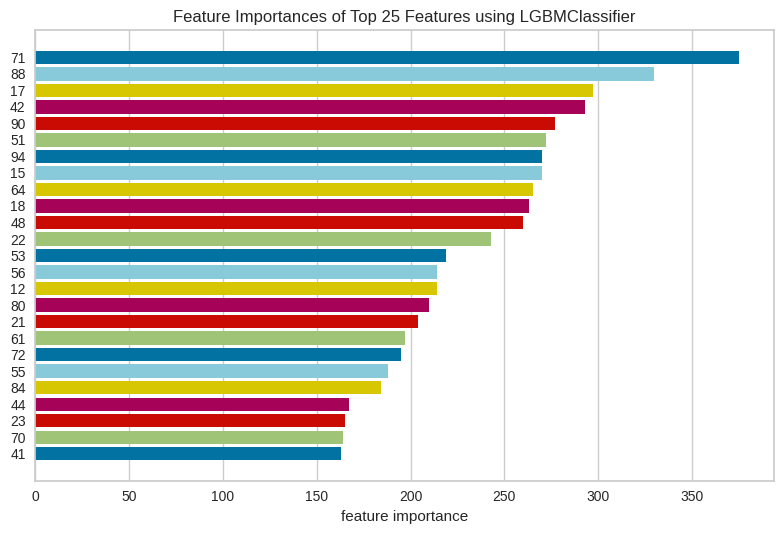

(None,)

In [127]:
experiment(
    "word embeddings ctx 3",
    "W2V_ext_ctx",
    lambda: LGBMClassifier(**best_params),
    np.array(X_train_words_and_ctx_encoded_3),
    np.array(X_test_holdout_words_and_ctx_encoded_3),
    np.array(X_test_unkn_words_and_ctx_encoded_3),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
),

### Собираем финальный инструмент

In [128]:
categorical_lgbm = LGBMClassifier(
    **{
        'learning_rate': 0.05,
        'n_estimators': 50,
        'max_depth': -1,
        'num_leaves': 30,
        'subsample': 0.6,
        'verbose': -1
    }
)

categorical_lgbm.fit(
    one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    )[0],
    y_train["aspect"]
)

LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=30,
               subsample=0.6, verbose=-1)

In [129]:
w2v_lgbm = LGBMClassifier(
    **{
        'learning_rate': 0.1,
        'n_estimators': 100,
        'max_depth': 7,
        'num_leaves': 30,
        'subsample': 0.6,
        'verbose': -1
    }
)

w2v_lgbm.fit(
    np.array(X_train_words_encoded + X_train_words_encoded),
    np.array(y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist())
)

LGBMClassifier(max_depth=7, num_leaves=30, subsample=0.6, verbose=-1)

In [130]:
categorical_columns = X_train_graphemes_and_grammar_categories.columns.tolist()
categorical_columns

['l_gr_1',
 'l_gr_2',
 'r_gr_1',
 'r_gr_2',
 'Gender',
 'Mood',
 'Number',
 'Person',
 'Tense',
 'VerbForm',
 'Voice']

In [131]:
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
onehot_encoder.fit(X_train[categorical_columns])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [132]:
class Predictor:
    """
        Пытается сделать предсказание по Word2Vec
        Если вектора нет, берет грамматику и графемы
    """

    def __init__(
        self,
        string_encoder,
        categorical_encoder,
        categorical_classifier,
        embedding_classifier
    ):
        self.string_encoder = string_encoder
        self.categorical_encoder = categorical_encoder
        self.categorical_classifier = categorical_classifier
        self.embedding_classifier = embedding_classifier

    def predict_(self, x):
        word, *categorical = x
        embedding = np.array(self.string_encoder.encode(word))

        if np.all(embedding == 0):
            oh_vector = self.categorical_encoder.transform(np.array(categorical).reshape(1, -1))
            pred = self.categorical_classifier.predict(oh_vector)
        else:
            pred = self.embedding_classifier.predict(embedding.reshape(1, -1))

        return pred[0]

    def predict(self, X):
        """
            X -- слово, категориальные фичи
        """

        result = [self.predict_(x) for x in X]
        return result

In [133]:
predictor = Predictor(encoder, onehot_encoder, categorical_lgbm, w2v_lgbm)

In [134]:
predictor.predict([["raditi", 1 ,2 ,3]])

['imp']

In [135]:
predictor.predict([["radio", 1 ,2 ,3]])

['imp']

In [136]:
predictor.predict([["radila", 1 ,2 ,3]])

['imp']

In [137]:
predictor.predict([["uraditi", 1 ,2 ,3]])

['perf']

In [138]:
predictor.predict([["uradio", 1 ,2 ,3]])

['perf']

In [139]:
predictor.predict([["uradila", 1 ,2 ,3]])

['perf']

In [140]:
categorical_columns

['l_gr_1',
 'l_gr_2',
 'r_gr_1',
 'r_gr_2',
 'Gender',
 'Mood',
 'Number',
 'Person',
 'Tense',
 'VerbForm',
 'Voice']

In [141]:
predictor.predict([["dobila", "d", "o", "a", "l", "Fem", "[PAD]", "Sing", "3", "Past", "Part", "Act"]])

['perf']

In [142]:
X_test_holdout_final = X_test_holdout[["word"] + categorical_columns]
X_test_holdout_final.head()

,word,l_gr_1,l_gr_2,r_gr_1,r_gr_2,Gender,Mood,Number,Person,Tense,VerbForm,Voice
3437,razgovara,r,a,a,r,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
1781,obećao,o,b,o,a,Masc,[PAD],Sing,[PAD],Past,Part,Act
4583,vidi,v,i,i,d,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
519,ima,i,m,a,m,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
571,imaju,i,m,u,j,[PAD],Ind,Plur,3,Pres,Fin,[PAD]


In [143]:
X_test_unkn_final = X_test_unkn[["word"] + categorical_columns]
X_test_unkn_final.head()

,word,l_gr_1,l_gr_2,r_gr_1,r_gr_2,Gender,Mood,Number,Person,Tense,VerbForm,Voice
36,boravi,b,o,i,v,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
37,boravi,b,o,i,v,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
38,boravila,b,o,a,l,Fem,[PAD],Sing,[PAD],Past,Part,Act
39,boravila,b,o,a,l,Fem,[PAD],Sing,[PAD],Past,Part,Act
40,boravio,b,o,o,i,Masc,[PAD],Sing,[PAD],Past,Part,Act


In [144]:
preds_holdout = predictor.predict(X_test_holdout_final.to_numpy())
preds_unkn    = predictor.predict(X_test_unkn_final.to_numpy())

to_print = [f"\n--- FINAL ---\n"]

f1_wtd_holdout = f1_score(y_test_holdout["aspect"], preds_holdout, average="weighted")
f1_wtd_unkn    = f1_score(y_test_unkn["aspect"], preds_unkn, average="weighted")
to_print.append(f"F1 weighted (Holdout): {f1_wtd_holdout:.3f}")
to_print.append(f"F1 weighted (Unknown): {f1_wtd_unkn:.3f}")

confusions_holdount = confusion_matrix(y_test_holdout["aspect"], preds_holdout)
confusions_unkn     = confusion_matrix(y_test_unkn["aspect"], preds_unkn)
to_print.append("Holdout confusion matrix")
to_print.append(confusions_holdount)
to_print.append("Unknown confusion matrix")
to_print.append(confusions_unkn)

holdout_report = classification_report(
    y_test_holdout["aspect"],
    preds_holdout,
    zero_division=1.0
)
unkn_report = classification_report(
    y_test_unkn["aspect"],
    preds_unkn,
    zero_division=1.0
)
to_print.append("Holdout report:")
to_print.append(holdout_report)
to_print.append("Unknown report:")
to_print.append(unkn_report)

list(
    map(lambda string: print(string, "\n"), to_print)
)


--- FINAL ---
 

F1 weighted (Holdout): 0.989 

F1 weighted (Unknown): 0.922 

Holdout confusion matrix 

[[273   3]
 [  3 271]] 

Unknown confusion matrix 

[[274  31]
 [ 12 233]] 

Holdout report: 

              precision    recall  f1-score   support

         imp       0.99      0.99      0.99       276
        perf       0.99      0.99      0.99       274

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.96      0.90      0.93       305
        perf       0.88      0.95      0.92       245

    accuracy                           0.92       550
   macro avg       0.92      0.92      0.92       550
weighted avg       0.92      0.92      0.92       550
 



[None, None, None, None, None, None, None, None, None, None, None]